<a href="https://colab.research.google.com/github/sgirabin/nyp-iti105-project/blob/main/ITI105_Project_Implementation_IsakRabin(4466624P).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITI105: Stock Price Prediction using Machine Learning

# Introduction

 We predict the direction of S&P 500 (Up / Down / Sideways) using classical ML. This is a 3‑class classification task trained on Yahoo Finance data and technical indicators.

 We compare Logistic Regression (baseline). Decision Tree, Random Forest, and xgBosst classifier, track experiments with MLflow.

# Pre-requisite

Before we start, we need to ensure all the libraries are available. For this project, we are using the following libraries

| Libraries | Description  | Reference |
|-----------|--------------|-----------|
| `yfinance` |  To download SP500 Historical Data | https://pypi.org/project/yfinance/ |
| `ta` |  To calculate technical indicator of SP500 which be used for training the model |  https://pypi.org/project/ta/ |
| `mlflow` | To logged our model experiments (training and tuning) | https://pypi.org/project/mlflow/ |



In [1144]:
# download and install yfinance , yfinance technical indicators, mlflow python library
!pip install yfinance ta mlflow pyngrok --upgrade --no-cache-dir

# Implementation

## Step 1: Import necessary libraries

In [1334]:
import yfinance as yf
import ta

import os
import getpass
import requests
import subprocess
import socket
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import mlflow

from google.colab import drive
from joblib import dump, load
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from pyngrok import ngrok, conf
from scipy.stats import norm

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (TimeSeriesSplit, GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix,precision_recall_curve, average_precision_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_fscore_support)
from xgboost import XGBClassifier

## Step 2: Importing Dataset



At first we need to download our dataset from Yahoo Finance. Our target dataset range is from **1st January 1970** to **30th June 2025**.

In [1432]:
# dataset parameter
TICKER = "^GSPC"
START_DATE = "1970-01-01"
END_DATE = "2025-06-30"

# percentage threshold for label movement
INITIAL_THRESHOLD = 0.5
ADJUSTED_THRESHOLD = 0.3

# storage
BASE_PATH = "/content/drive/MyDrive/NYP/ITI105"
MLFLOW_PATH = f"{BASE_PATH}/mllogs"
MODELS_PATH = f"{MLFLOW_PATH}/models"

# Input File
FILE_NAME = "sp500_daily_history.csv"

# ngrok token
NGROK_TOKEN = "2t8TIG1geBuF6yFcNXZYkkxTqzg_7qGykBf4NYA9AKwvB9u8R"
PORT = 5000

In [1433]:
# Mount Google Drive
drive.mount("/content/drive")

os.makedirs(os.path.dirname(BASE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(MLFLOW_PATH), exist_ok=True)
os.makedirs(os.path.dirname(MODELS_PATH), exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1434]:
# Function to load the data
def load_price_data(ticker=TICKER, start=START_DATE,
                    end=END_DATE, filename=FILE_NAME):

    data_path = os.path.join(BASE_PATH, filename)
    if os.path.exists(data_path):
        df = pd.read_csv(data_path, parse_dates=["Date"])
        df = df.sort_values("Date").reset_index(drop=True).set_index("Date")
        return df

    df = yf.download(ticker, start=start, end=end,
                     auto_adjust=False, progress=False)
    df = df.rename_axis("Date").reset_index()

    # save CSV with Date column
    df.to_csv(data_path, index=False)
    return df

In [1435]:
# Load the data
raw_data = load_price_data()

In [1436]:
# Check first 5 rows of our dataset
print("\nFirst 5 rows:")
print(raw_data.head())


First 5 rows:
                    Adj Close              Close               High  \
Date                                                                  
1970-01-02               93.0               93.0  93.54000091552734   
1970-01-05  93.45999908447266  93.45999908447266              94.25   
1970-01-06  92.81999969482422  92.81999969482422  93.80999755859375   
1970-01-07  92.62999725341797  92.62999725341797  93.37999725341797   
1970-01-08  92.68000030517578  92.68000030517578  93.47000122070312   

                          Low               Open    Volume  
Date                                                        
1970-01-02  91.79000091552734  92.05999755859375   8050000  
1970-01-05  92.52999877929688               93.0  11490000  
1970-01-06  92.12999725341797  93.45999908447266  11460000  
1970-01-07  91.93000030517578  92.81999969482422  10010000  
1970-01-08  91.98999786376953  92.62999725341797  10670000  


## Step 3: Data Preparations

### Step 3.1: Data Structure Analysis

In [1437]:
# Show dataset shape
print("Data shape:", raw_data.shape)

Data shape: (13993, 6)


In [1438]:
# Show data types
print("\nData types:")
print(raw_data.dtypes)


Data types:
Adj Close    object
Close        object
High         object
Low          object
Open         object
Volume       object
dtype: object


In [1439]:
# Basic info
print("\nBasic Info:")
print(raw_data.info())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13993 entries, 1970-01-02 to NaT
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Adj Close  13993 non-null  object
 1   Close      13993 non-null  object
 2   High       13993 non-null  object
 3   Low        13993 non-null  object
 4   Open       13993 non-null  object
 5   Volume     13993 non-null  object
dtypes: object(6)
memory usage: 765.2+ KB
None


In [1440]:
# Sumnmary Statistic
print("\nSummary statistics:")
print(raw_data.describe())


Summary statistics:
                 Adj Close               Close                High  \
count                13993               13993               13993   
unique               12740               12740               12738   
top     102.08999633789062  102.08999633789062  105.41000366210938   
freq                     7                   7                   7   

                      Low                Open      Volume  
count               13993               13993       13993  
unique              12747               12761       12368  
top     100.3499984741211  102.08999633789062  4223740000  
freq                    6                   8          12  


In [1441]:
# Check for missing values
raw_data.isnull().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [1442]:
# Check any duplicate records
raw_data.duplicated().sum()

np.int64(0)

In [1443]:
# check index type and range
raw_data.index

DatetimeIndex(['1970-01-02', '1970-01-05', '1970-01-06', '1970-01-07',
               '1970-01-08', '1970-01-09', '1970-01-12', '1970-01-13',
               '1970-01-14', '1970-01-15',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-20',
               '2025-06-23', '2025-06-24', '2025-06-25', '2025-06-26',
               '2025-06-27',        'NaT'],
              dtype='datetime64[ns]', name='Date', length=13993, freq=None)

### Step 3.2: First Exploratory Data Analysis

#### Step 3.2.1: Raw Feature Distributions

First, we want to  analyze the raw feature distributions of the OHLC (Open, High, Low, Close) and Volume columns. This helps us understand how the data is spread, detect anomalies, and see whether features have very different scales or skewed distributions.

It is important because:
- It provides a baseline view of the dataset before cleaning and feature engineering.
- It helps us decide if transformations (e.g., log scaling) are needed.
- It highlights unusual values or inconsistencies that may need to be handled.

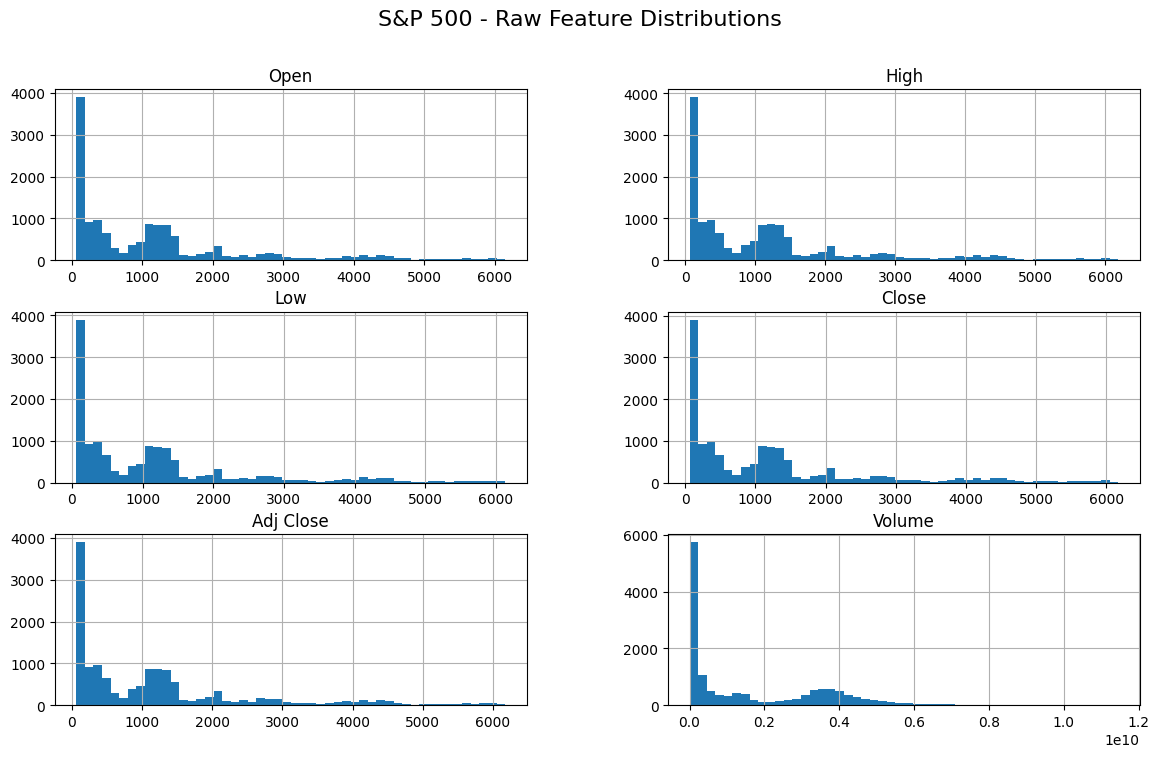

In [1444]:
# Analyze raw feature distributions
numeric_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
raw_data[numeric_cols] = raw_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

raw_data[numeric_cols].hist(bins=50, figsize=(14, 8))
plt.suptitle("S&P 500 - Raw Feature Distributions", fontsize=16)
plt.show()

Before creating engineered features, we generate a correlation heatmap of the raw features.
This helps us:
- Understand the baseline relationships between OHLC and Volume data.
- Identify redundant or highly correlated features that may cause multicollinearity.
- Plan which features are worth keeping and which may be dropped later.
- Provide a baseline comparison so that when we add technical indicators, we can check if they bring new information or are just duplicating what already exists.

Doing this step before feature engineering ensures that our dataset remains clean, avoids unnecessary redundancy, and supports better feature selection during modeling.

#### Step 3.2.2: Feature Correlation Heatmap

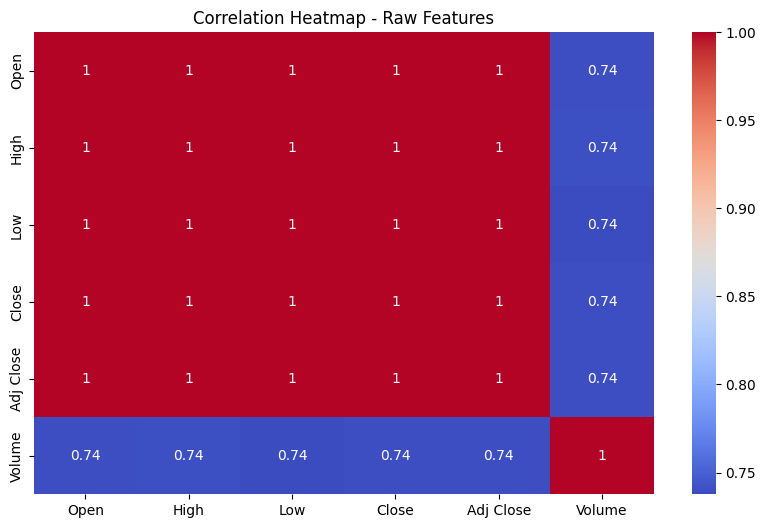

In [1445]:
# Correlation Heatmap for each feature
plt.figure(figsize=(10, 6))
sns.heatmap(raw_data[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap - Raw Features")
plt.show()

#### Step 3.2.3: Price Analysis

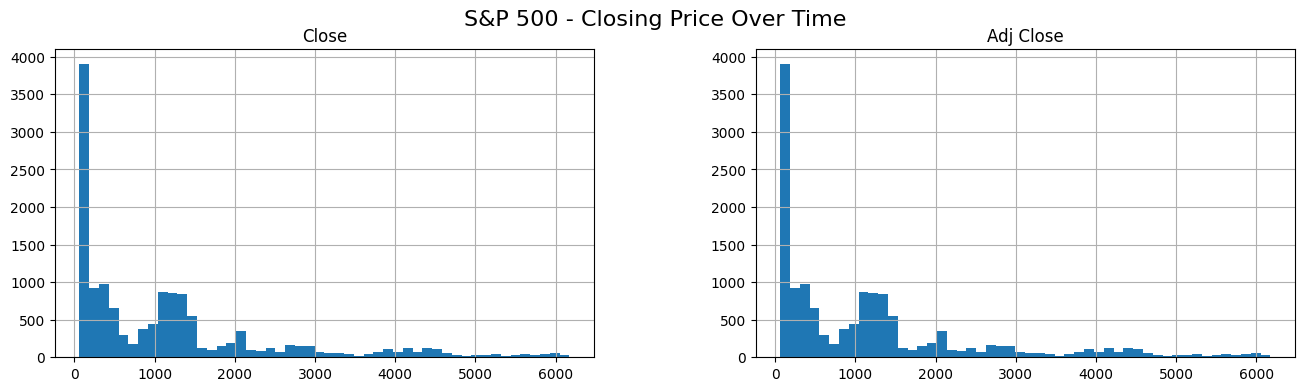

In [1446]:
# Identify trends and patterns
closing_price = ["Close", "Adj Close"]
raw_data[closing_price] = raw_data[closing_price].apply(pd.to_numeric, errors="coerce")

raw_data[closing_price].hist(bins=50, figsize=(16, 4))
plt.suptitle("S&P 500 - Closing Price Over Time", fontsize=16)
plt.show()

In [1447]:
# Check if any different between Adj Close and Close
closing_price_diff = raw_data["Adj Close"] - raw_data["Close"]

print("Summary statistics of Adj Close - Close:")
print(closing_price_diff.describe())

Summary statistics of Adj Close - Close:
count    13992.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64


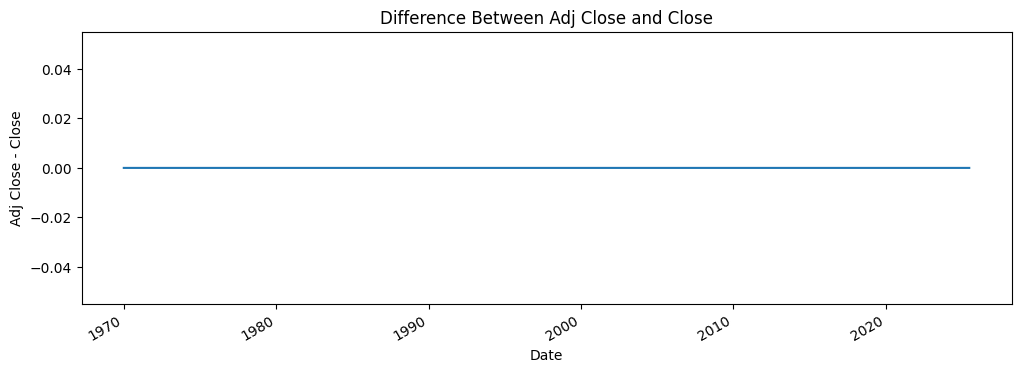

In [1448]:
# Plot the difference between Adj Close and Close
closing_price_diff.plot(figsize=(12,4), title="Difference Between Adj Close and Close")
plt.ylabel("Adj Close - Close")
plt.show()

No difference found between `Close` and `Adj Close`. We can just use `Close`.

Next, we want to visualize the distribution of each price feature  and identify their central values (medians), spread (interquartile range), and outliers.

This helps us to:
1. Check data consistency across OHLC prices — they should follow similar distributions.
2. Detect extreme values — which may represent either true market shocks (e.g., crashes or surges) or potential anomalies in the data.
3. Understand the overall volatility and range of the index.
4. Decide whether data transformations (e.g., log scaling or normalization) are needed, and avoid redundancy if features are too similar.

By doing this, we gain insights into the historical growth of the S&P 500 and ensure the dataset is reliable before moving into feature engineering and model training.

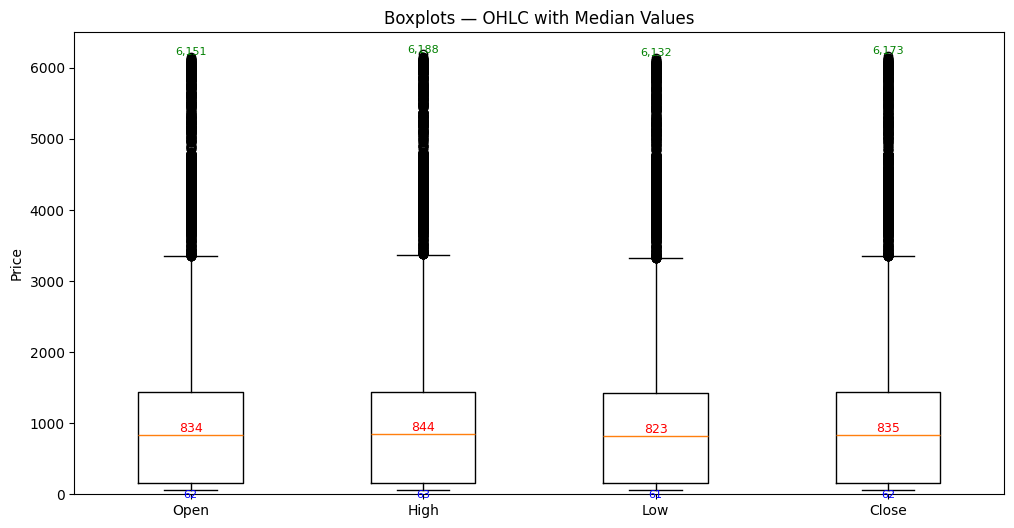

In [1449]:
# Boxplot of price columns
price_cols = [c for c in ["Open", "High", "Low", "Close"] if c in raw_data.columns]
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot([raw_data[c].dropna() for c in price_cols],
                tick_labels=price_cols, showfliers=True)

# Annotate min, median, and max for each column
for i, col in enumerate(price_cols, start=1):
    col_data = raw_data[col].dropna()
    min_val = col_data.min()
    median_val = col_data.median()
    max_val = col_data.max()

    ax.text(i, min_val, f"{min_val:,.0f}", ha="center", va="top", fontsize=8, color="blue")
    ax.text(i, median_val, f"{median_val:,.0f}", ha="center", va="bottom", fontsize=9, color="red")
    ax.text(i, max_val, f"{max_val:,.0f}", ha="center", va="bottom", fontsize=8, color="green")

ax.set_ylim(0, 6500)
ax.set_title("Boxplots — OHLC with Median Values")
ax.set_ylabel("Price")
plt.show()

#### Step 3.2.4: Volatility and Trends Patterns

Next, we calculate and plot rolling volatility of the S&P 500 index.
Volatility is measured as the rolling standard deviation of daily percentage changes in the closing price.

By plotting rolling volatility, we can:
1. Identify periods of high volatility (e.g., market crashes or crises).
2. Identify stable, low-volatility periods (e.g., steady growth phases).
3. Capture time-varying patterns that can be useful features for our machine learning model.

This analysis is important because volatility is a key financial indicator that often influences market movements and can improve our prediction of Up/Down/Sideways trends.

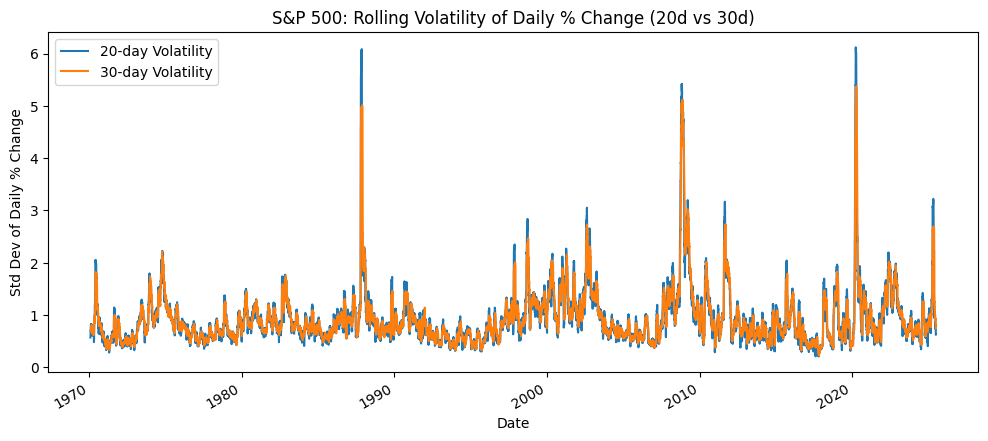

In [1450]:
# Daily % change (returns)
ret_pct = raw_data["Close"].pct_change(fill_method=None).mul(100)

# Rolling volatility of daily % change
volatility = pd.DataFrame(index=raw_data.index)
volatility["Volatility_20d"] = ret_pct.rolling(window=20, min_periods=20).std()
volatility["Volatility_30d"] = ret_pct.rolling(window=30, min_periods=30).std()

# Plot
ax = volatility[["Volatility_20d", "Volatility_30d"]].plot(
    figsize=(12, 5), title="S&P 500: Rolling Volatility of Daily % Change (20d vs 30d)"
)
ax.set_ylabel("Std Dev of Daily % Change")
ax.legend(["20-day Volatility", "30-day Volatility"])


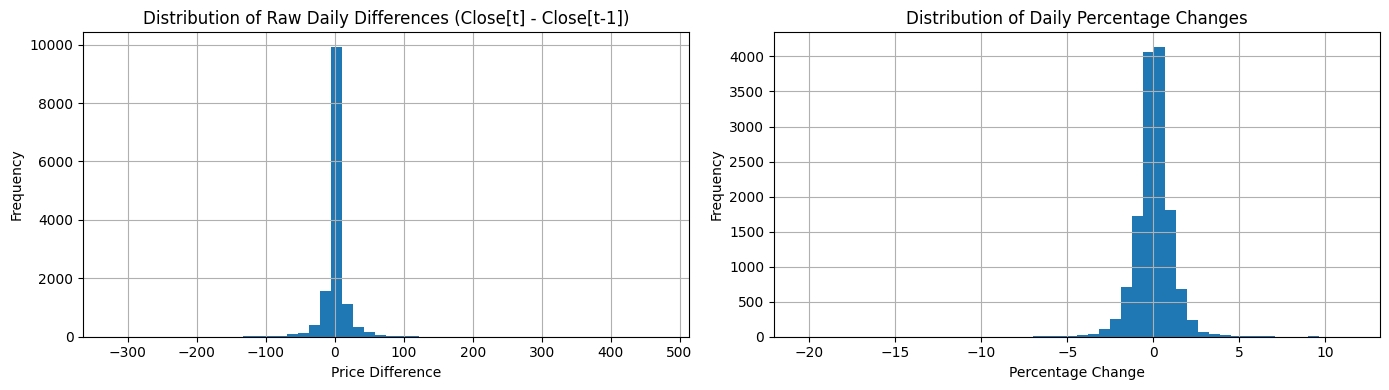

In [1451]:
daily_returns = raw_data["Close"].diff()
daily_returns_pct = raw_data["Close"].pct_change(fill_method=None).mul(100)

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
daily_returns.hist(bins=50)
plt.title("Distribution of Raw Daily Differences (Close[t] - Close[t-1])")
plt.xlabel("Price Difference")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
daily_returns_pct.hist(bins=50)
plt.title("Distribution of Daily Percentage Changes")
plt.xlabel("Percentage Change")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [1452]:
#check the stats of daily percentage return
daily_returns_pct.describe()

,Close
count,13991.000000
mean,0.035904
std,1.084822
min,-20.466931
25%,-0.460576
50%,0.048271
75%,0.559791
max,11.580037


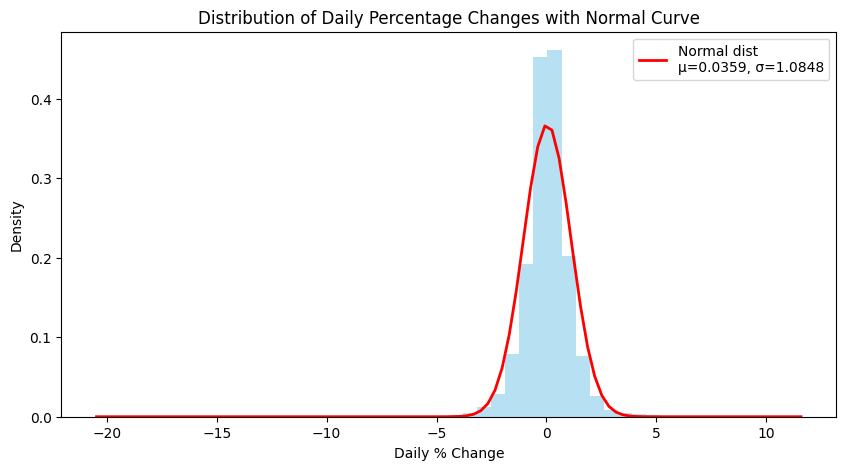

In [1453]:
# Daily percentage returns
daily_returns_pct = raw_data["Close"].pct_change(fill_method=None).mul(100).dropna()

# Fit a normal distribution (mean & std from data)
mu, sigma = daily_returns_pct.mean(), daily_returns_pct.std()

# Plot histogram of daily returns
plt.figure(figsize=(10,5))
count, bins, ignored = plt.hist(daily_returns_pct, bins=50, density=True, alpha=0.6, color="skyblue")

# Overlay normal distribution curve
x = np.linspace(bins.min(), bins.max(), 100)
plt.plot(x, norm.pdf(x, mu, sigma), "r", linewidth=2, label=f"Normal dist\nμ={mu:.4f}, σ={sigma:.4f}")

plt.title("Distribution of Daily Percentage Changes with Normal Curve")
plt.xlabel("Daily % Change")
plt.ylabel("Density")
plt.legend()
plt.show()

In [1454]:
#Identify Extreme Price Moves (>10% daily change)
extreme_moves = raw_data[raw_data["Close"].pct_change(fill_method=None).mul(100).abs() > 10]
print(extreme_moves)

              Adj Close        Close         High          Low         Open  \
Date                                                                          
1987-10-19   224.839996   224.839996   282.700012   224.830002   282.700012   
2008-10-13  1003.349976  1003.349976  1006.929993   912.750000   912.750000   
2008-10-28   940.510010   940.510010   940.510010   845.270020   848.919983   
2020-03-16  2386.129883  2386.129883  2562.979980  2380.939941  2508.590088   

                  Volume  
Date                      
1987-10-19  6.043000e+08  
2008-10-13  7.263370e+09  
2008-10-28  7.096950e+09  
2020-03-16  7.805450e+09  


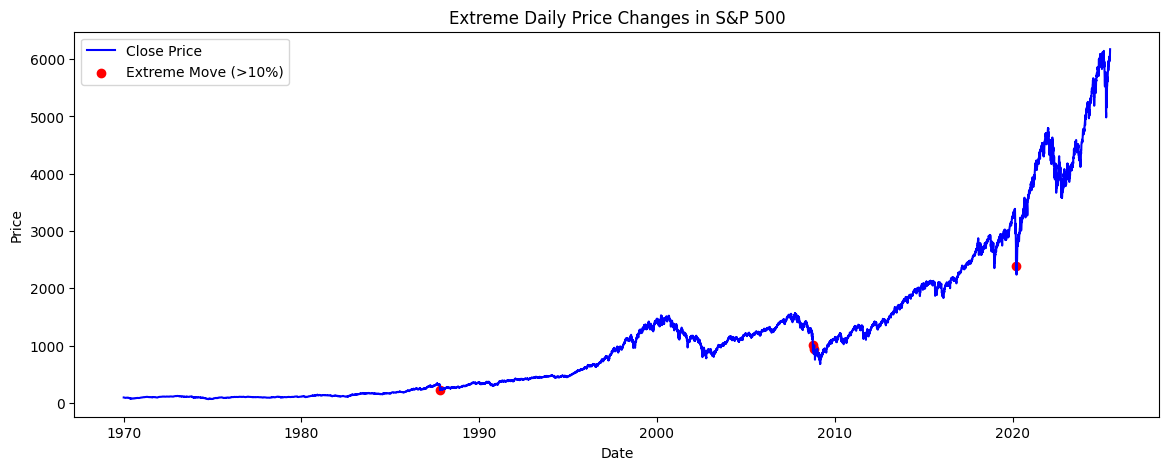

In [1455]:
plt.figure(figsize=(14,5))
plt.plot(raw_data.index, raw_data["Close"], label="Close Price", color="blue")
plt.scatter(extreme_moves.index, extreme_moves["Close"], color="red", label="Extreme Move (>10%)")
plt.title("Extreme Daily Price Changes in S&P 500")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: title={'center': 'S&P 500 Volume Over Time'}, xlabel='Date'>

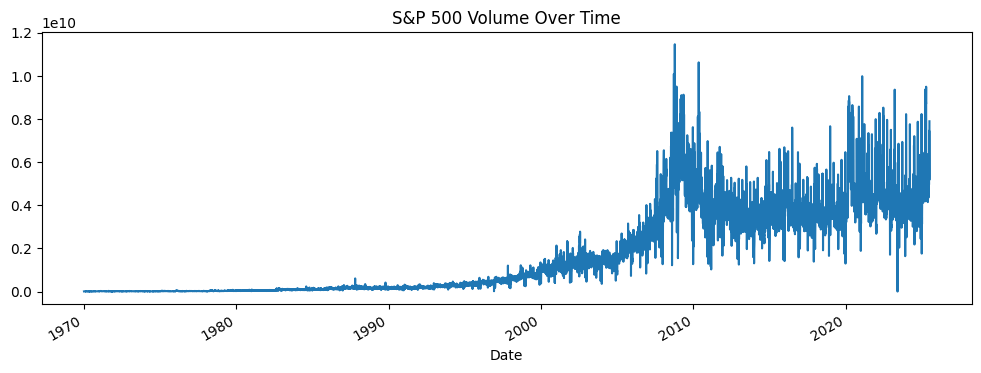

In [1456]:
# Volume trend plot
raw_data["Volume"].plot(figsize=(12,4), title="S&P 500 Volume Over Time")

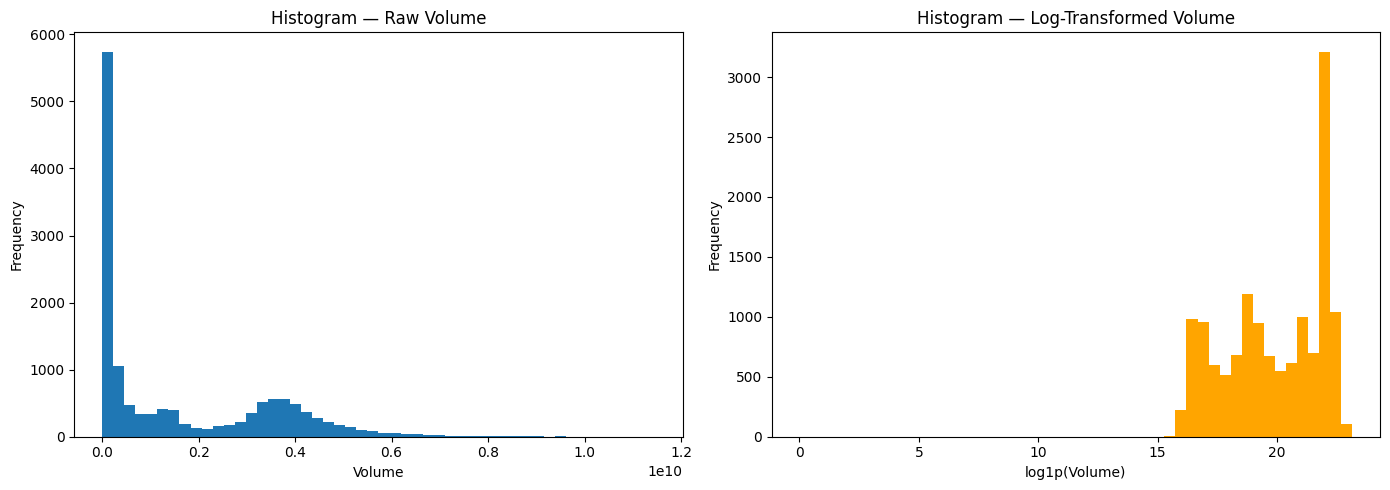

In [1457]:
# Raw and log-transformed volume
raw_volume = raw_data["Volume"].dropna()
log_volume = np.log1p(raw_volume)   # log(1+x) to avoid log(0)

# Side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw volume histogram
axes[0].hist(raw_volume, bins=50)
axes[0].set_title("Histogram — Raw Volume")
axes[0].set_xlabel("Volume")
axes[0].set_ylabel("Frequency")

# Log-transformed volume histogram
axes[1].hist(log_volume, bins=50, color="orange")
axes[1].set_title("Histogram — Log-Transformed Volume")
axes[1].set_xlabel("log1p(Volume)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

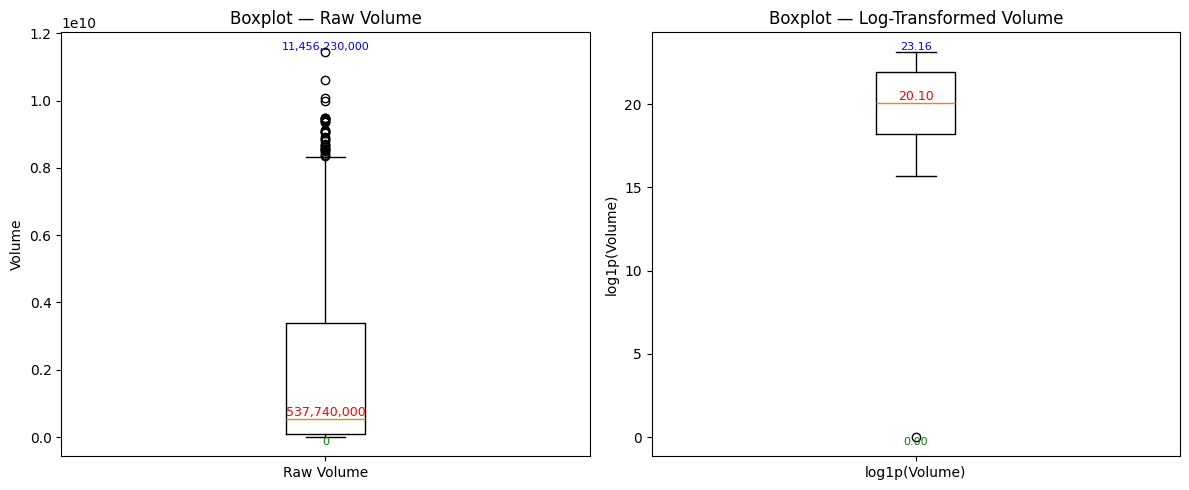

In [1458]:
# Boxplots with annotated min, median, max
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw volume boxplot
bp_raw = axes[0].boxplot(raw_volume, tick_labels=["Raw Volume"], showfliers=True)
axes[0].set_title("Boxplot — Raw Volume")
axes[0].set_ylabel("Volume")

# Annotate values
min_val = raw_volume.min()
median_val = raw_volume.median()
max_val = raw_volume.max()
axes[0].text(1, min_val, f"{min_val:,.0f}", ha="center", va="top", fontsize=8, color="green")
axes[0].text(1, median_val, f"{median_val:,.0f}", ha="center", va="bottom", fontsize=9, color="red")
axes[0].text(1, max_val, f"{max_val:,.0f}", ha="center", va="bottom", fontsize=8, color="blue")

# Log-transformed volume boxplot
bp_log = axes[1].boxplot(log_volume, tick_labels=["log1p(Volume)"], showfliers=True)
axes[1].set_title("Boxplot — Log-Transformed Volume")
axes[1].set_ylabel("log1p(Volume)")

# Annotate values
min_val_log = log_volume.min()
median_val_log = log_volume.median()
max_val_log = log_volume.max()
axes[1].text(1, min_val_log, f"{min_val_log:.2f}", ha="center", va="top", fontsize=8, color="green")
axes[1].text(1, median_val_log, f"{median_val_log:.2f}", ha="center", va="bottom", fontsize=9, color="red")
axes[1].text(1, max_val_log, f"{max_val_log:.2f}", ha="center", va="bottom", fontsize=8, color="blue")

fig.tight_layout()
fig.show()

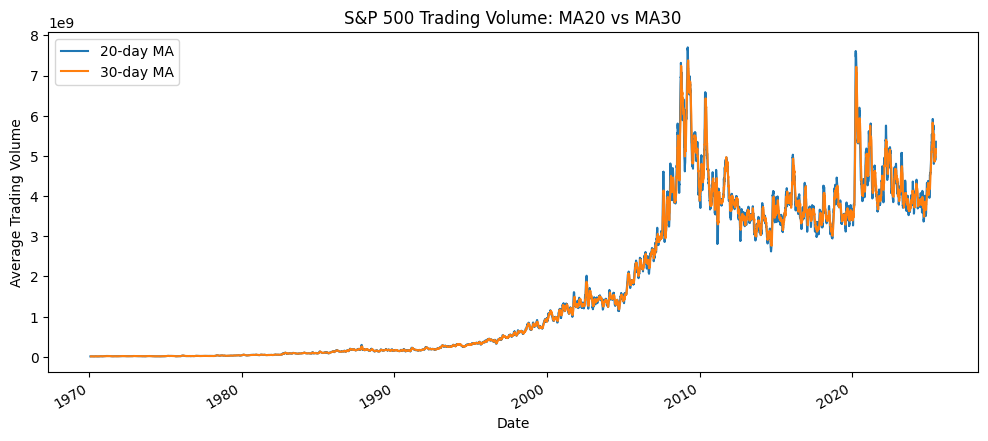

In [1459]:
# Calculate 20-day and 30-day moving averages of Volume
volume = raw_data.copy()
volume["Volume_MA20"] = volume["Volume"].rolling(window=20).mean()
volume["Volume_MA30"] = volume["Volume"].rolling(window=30).mean()

# Plot both on the same chart
ax = volume[["Volume_MA20", "Volume_MA30"]].plot(figsize=(12,5),
                                                   title="S&P 500 Trading Volume: MA20 vs MA30")
ax.set_ylabel("Average Trading Volume")
ax.legend(["20-day MA", "30-day MA"])

### Step 3.2: Data Cleaning

In [1460]:
# Data Cleaning: Reset index to ensure Date is a column
raw_data.reset_index(inplace=True)

In [1461]:
# Data Cleaning: Remove rows with missing Close
clean_data = raw_data.dropna(subset=["Close"]).copy()

In [1462]:
# Data Cleaning: Missing Values Handling

# Check missing values first
missing_summary = clean_data.isnull().sum()
print("Missing values before cleaning:\n", missing_summary[missing_summary > 0])

# Forward fill for time-series continuity
clean_data.ffill(inplace=True)

# If still missing values remain (e.g., at the very start), backfill
clean_data.bfill(inplace=True)

# Final check
print("\nMissing values after cleaning:", clean_data.isnull().sum().sum())

Missing values before cleaning:
 Series([], dtype: int64)

Missing values after cleaning: 0


In [1463]:
# Data Cleaning: Remove non-trading days ===

# Before removal
print(f"Rows before filtering: {clean_data.shape[0]}")
zero_volume_days = clean_data[clean_data["Volume"] == 0]
print(f"Non-trading days found: {zero_volume_days.shape[0]}")

# Remove rows where trading volume is zero
clean_data = clean_data[clean_data["Volume"] > 0].copy()

# After removal
print(f"Rows after filtering: {clean_data.shape[0]}")

Rows before filtering: 13992
Non-trading days found: 1
Rows after filtering: 13991


In [1464]:
# Data Cleaning:  Ensure date order is ascending ===
clean_data.sort_values("Date", inplace=True)

In [1465]:
# Data Cleaning: Remove duplicate data ===
clean_data = clean_data[~clean_data.index.duplicated(keep="first")]

In [1466]:
# Data Cleaning:  Reset index again for clean integer index ===
clean_data.reset_index(drop=True, inplace=True)

In [1467]:
# Data Cleaning:  Final Check ===
print("Final dataset shape:", clean_data.shape)
print("Missing values:", clean_data.isnull().sum().sum())
print("Date range:", clean_data["Date"].min(), "to", clean_data["Date"].max())

Final dataset shape: (13991, 7)
Missing values: 0
Date range: 1970-01-02 00:00:00 to 2025-06-27 00:00:00


### Step 3.3: Feature Engineering - Label Construction

In [1468]:
# Function to classify movement
def classify_movement(pct, threshold):
    if pct >= threshold:
        return "Up"
    elif pct <= -threshold:
        return "Down"
    else:
        return "Sideway"

In [1469]:
# Calculate percentage change between today"s and tomorrow"s close
clean_data["Pct_Change"] = clean_data["Close"].pct_change(fill_method=None).mul(100).dropna()

In [1470]:
# Apply classification - 0.3
clean_data["movement_label_05"] = clean_data["Pct_Change"].apply(classify_movement, args=(INITIAL_THRESHOLD,))
clean_data["movement_label_03"] = clean_data["Pct_Change"].apply(classify_movement, args=(ADJUSTED_THRESHOLD,))

In [1471]:
# Drop any rows with NaN in movement_label (last row will be NaN because shift(-1) has no tomorrow)
clean_data.dropna(subset=["movement_label_05", "movement_label_03"], inplace=True)

In [1472]:
# Check class distribution 0.5%
class_counts_05 = clean_data["movement_label_05"].value_counts()
class_percents_05 = clean_data["movement_label_05"].value_counts(normalize=True) * 100

print("Threshold 0.5%  - Class distribution:\n", class_counts_05)
print("\nThreshold 0.5%  - Class distribution (%):\n", class_percents_05)

Threshold 0.5%  - Class distribution:
 movement_label_05
Sideway    6859
Up         3809
Down       3323
Name: count, dtype: int64

Threshold 0.5%  - Class distribution (%):
 movement_label_05
Sideway    49.024373
Up         27.224644
Down       23.750983
Name: proportion, dtype: float64


In [1473]:
# Check class distribution 0.3%
class_counts_03 = clean_data["movement_label_03"].value_counts()
class_percents_03 = clean_data["movement_label_03"].value_counts(normalize=True) * 100

print("Threshold 0.3%  - Class distribution:\n", class_counts_03)
print("\nThreshold 0.3%  - Class distribution (%):\n", class_percents_03)

Threshold 0.3%  - Class distribution:
 movement_label_03
Up         5038
Sideway    4604
Down       4349
Name: count, dtype: int64

Threshold 0.3%  - Class distribution (%):
 movement_label_03
Up         36.008863
Sideway    32.906869
Down       31.084268
Name: proportion, dtype: float64


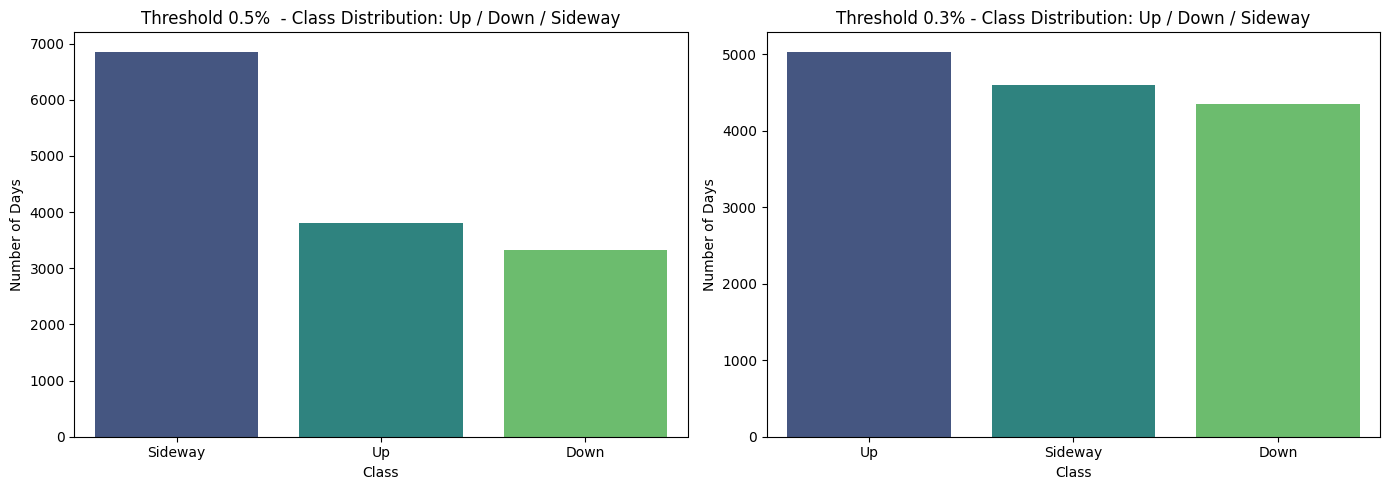

In [1474]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot class distribution 0.5%
sns.barplot(x=class_counts_05.index, y=class_counts_05.values,palette="viridis", hue=class_percents_05.index, ax=axes[0])
axes[0].set_xlabel("Movement Label")
axes[0].set_ylabel("Count")
axes[0].set_title("Threshold 0.5%  - Class Distribution: Up / Down / Sideway")
axes[0].set_ylabel("Number of Days")
axes[0].set_xlabel("Class")

# Plot class distribution 0.3%
sns.barplot(x=class_counts_03.index, y=class_counts_03.values, palette="viridis", hue=class_percents_03.index, ax=axes[1] )
axes[1].set_xlabel("Movement Label")
axes[1].set_ylabel("Count")
axes[1].set_title("Threshold 0.3% - Class Distribution: Up / Down / Sideway")
axes[1].set_ylabel("Number of Days")
axes[1].set_xlabel("Class")

plt.tight_layout()
plt.show()

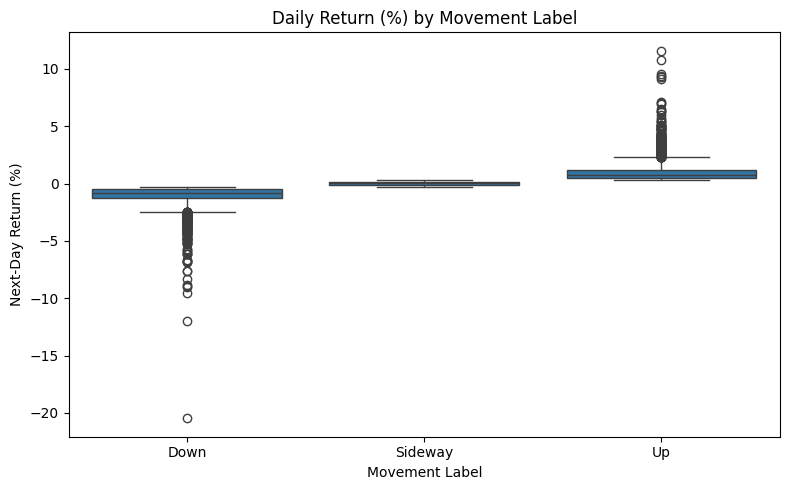

In [1475]:
# Drop the last NaN-return row (from shift(-1))
df_ret = clean_data.dropna(subset=["Pct_Change", "movement_label_03"]).copy()

order = ["Down", "Sideway", "Up"]
fig, ax = plt.subplots(figsize=(8, 5))
if "sns" in globals():
    sns.boxplot(data=df_ret, x="movement_label_03", y="Pct_Change",
                order=order, ax=ax, showfliers=True)
else:
    # Fallback to matplotlib
    groups = [df_ret.loc[df_ret["movement_label_03"] == k, "Pct_Change"] for k in order]
    ax.boxplot(groups, labels=order, showfliers=True)

ax.set_title("Daily Return (%) by Movement Label")
ax.set_xlabel("Movement Label")
ax.set_ylabel("Next-Day Return (%)")
fig.tight_layout()
fig.savefig("fig_boxplot_returns_by_label.png")
plt.show()

### Step 3.4: Feature Engineering - Technical Ididcators

In [1476]:
# 1. Moving Averages (MA5, MA10, MA20)
clean_data["MA5"] = clean_data["Close"].rolling(window=5).mean()
clean_data["MA10"] = clean_data["Close"].rolling(window=10).mean()
clean_data["MA20"] = clean_data["Close"].rolling(window=20).mean()

In [1477]:
# 2. Relative Strength Index (RSI)
clean_data["RSI"] = ta.momentum.RSIIndicator(close=clean_data["Close"], window=14).rsi()

In [1478]:
# 3. MACD and MACD Signal
macd_indicator = ta.trend.MACD(close=clean_data["Close"])
clean_data["MACD"] = macd_indicator.macd()
clean_data["MACD_signal"] = macd_indicator.macd_signal()

In [1479]:
# 4. Exponential Moving Averages (EMA10, EMA20)
clean_data["EMA10"] = ta.trend.EMAIndicator(close=clean_data["Close"], window=10).ema_indicator()
clean_data["EMA20"] = ta.trend.EMAIndicator(close=clean_data["Close"], window=20).ema_indicator()

In [1480]:
# 5. Bollinger Band Width
bb_indicator = ta.volatility.BollingerBands(close=clean_data["Close"], window=20)
clean_data["BB_width"] = bb_indicator.bollinger_wband()

In [1481]:
# 6. Average True Range (ATR)
atr_indicator = ta.volatility.AverageTrueRange(
    high=clean_data["High"],
    low=clean_data["Low"],
    close=clean_data["Close"],
    window=14
)
clean_data["ATR"] = atr_indicator.average_true_range()

In [1482]:
# 7. Stochastic Oscillator (%K and %D)
stoch_k = ta.momentum.StochasticOscillator(
    high=clean_data["High"],
    low=clean_data["Low"],
    close=clean_data["Close"],
    window=14,
    smooth_window=3
)
clean_data["Stoch_K"] = stoch_k.stoch()
clean_data["Stoch_D"] = stoch_k.stoch_signal()

In [1483]:
# Drop NaN values from the start due to rolling calculations
clean_data.dropna(inplace=True)

# Check final shape
print("Dataset shape after adding indicators:", clean_data.shape)

Dataset shape after adding indicators: (13958, 22)


### Step 3.5: Other Feature Engineering

In [1484]:
# Log‑transformed Volume  —— reduces extreme skew
clean_data["log_volume"] = np.log1p(raw_data["Volume"].dropna())

In [1485]:
# 20‑day Moving Average of Volume —— trend in market participation
clean_data["MA_volume_20"] = clean_data["Volume"].rolling(window=20).mean()

In [1486]:
# Daily Range (intraday volatility proxy)
clean_data["daily_range"] = clean_data["High"] - clean_data["Low"]

In [1487]:
# Close‑to‑Open Gap (overnight sentiment)
clean_data["close_to_open_gap"] = clean_data["Open"] - clean_data["Close"].shift(1)

In [1488]:
# Drop movement_label_05,  Rename movement_label_03 → movement_label
clean_data = (
    clean_data
    .drop(columns=["Adj Close", "Volume", "movement_label_05"], errors="ignore")
    .rename(columns={"movement_label_03": "movement_label"})
)

In [1489]:
# add movement label - numeric
label_map = {"Down": 0, "Sideway": 1, "Up": 2}
clean_data["movement_label_num"] = clean_data["movement_label"].map(label_map)

In [1490]:
clean_data.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Pct_Change,0
movement_label,0
MA5,0
MA10,0
MA20,0


In [1491]:
clean_data.ffill(inplace=True)
clean_data.bfill(inplace=True)

In [1492]:
clean_data.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Pct_Change,0
movement_label,0
MA5,0
MA10,0
MA20,0


In [1493]:
print(clean_data.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Pct_Change', 'movement_label',
       'MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_signal', 'EMA10', 'EMA20',
       'BB_width', 'ATR', 'Stoch_K', 'Stoch_D', 'log_volume', 'MA_volume_20',
       'daily_range', 'close_to_open_gap', 'movement_label_num'],
      dtype='object')


In [1494]:
clean_data.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Pct_Change,0
movement_label,0
MA5,0
MA10,0
MA20,0


### Step 3.6: Second Exploratory Data Analysis

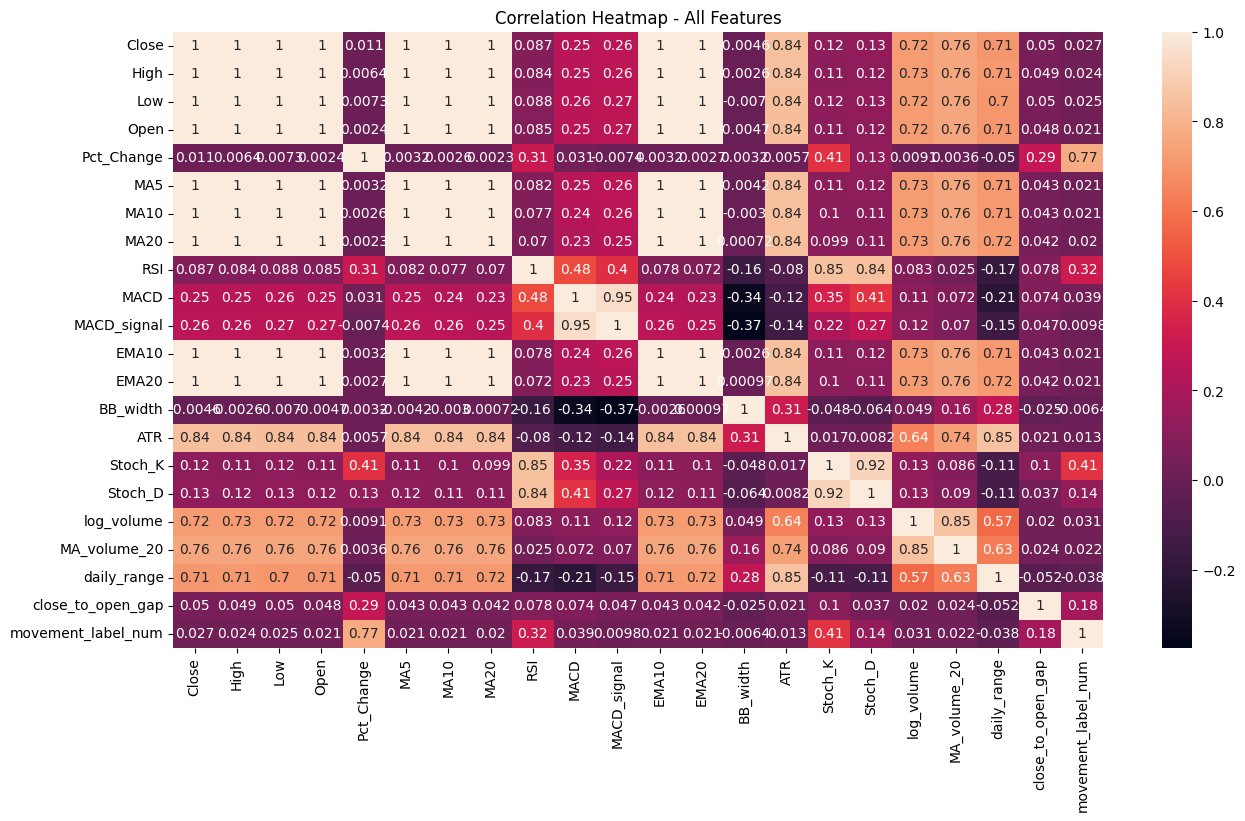

In [1495]:
# Correlation Matrics
plt.subplots(figsize=(15, 8))
corr = clean_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.title("Correlation Heatmap - All Features")
plt.show()

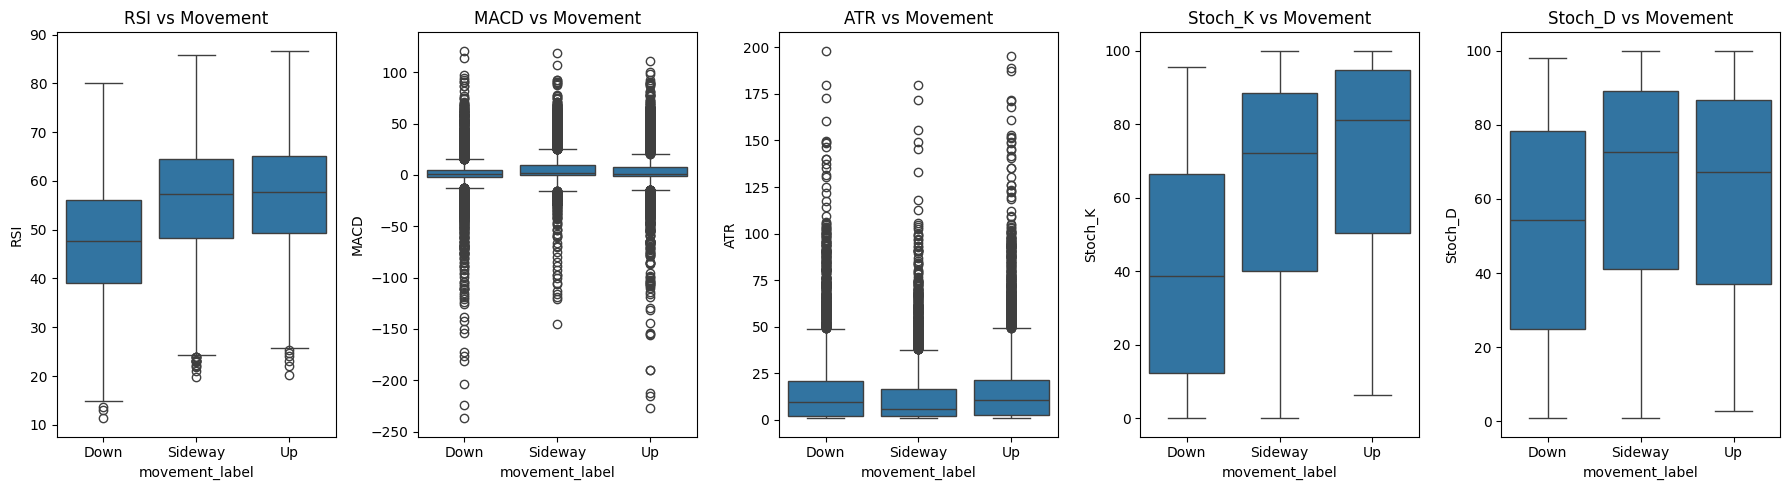

In [1496]:
# Pick a few key features to visualize
features_to_plot = ["RSI", "MACD", "ATR", "Stoch_K", "Stoch_D"]

fig, axes = plt.subplots(1, len(features_to_plot), figsize=(18, 5), sharey=False)
for i, col in enumerate(features_to_plot):
    sns.boxplot(x="movement_label", y=col, data=clean_data, ax=axes[i], order=["Down", "Sideway", "Up"])
    axes[i].set_title(f"{col} vs Movement")
plt.tight_layout()
plt.show()


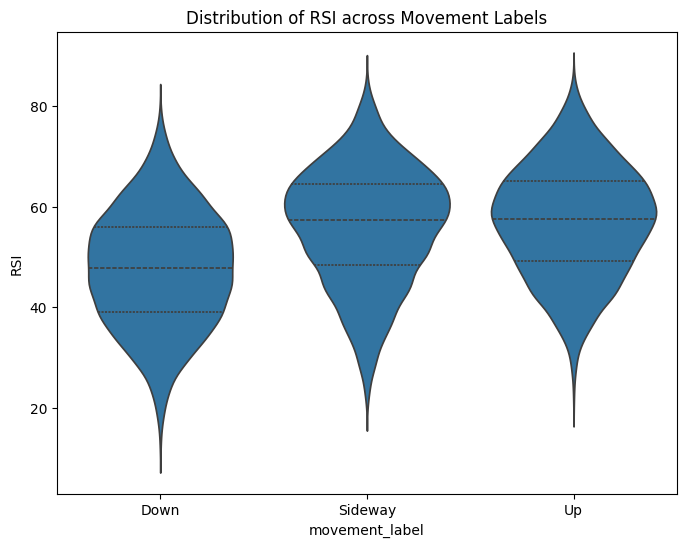

In [1497]:
plt.figure(figsize=(8,6))
sns.violinplot(x="movement_label", y="RSI", data=clean_data, order=["Down", "Sideway", "Up"], inner="quartile")
plt.title("Distribution of RSI across Movement Labels")
plt.show()

In [1498]:
# Check if balancing is needed
def check_imbalance(percent_max, percent_min):
    imbalance_ratio = percent_max / percent_min
    print(f"\nImbalance Ratio (max/min class size): {imbalance_ratio:.2f}")

    if imbalance_ratio > 1.5:
        print("Significant class imbalance detected. Consider balancing techniques such as SMOTE, undersampling, or class-weight adjustment.")
    else:
        print("Classes are reasonably balanced. No balancing needed.")

check_imbalance(class_percents_03.max(), class_percents_03.min())


Imbalance Ratio (max/min class size): 1.16
Classes are reasonably balanced. No balancing needed.


### Step 3.7: Timed-based Dataset Split

In [1499]:
# Ensure data is sorted by Date
clean_data.sort_values("Date", inplace=True)

In [1500]:
# Split the data
clean_data["Date"] = pd.to_datetime(clean_data["Date"], utc=True)

train_df = clean_data[(clean_data["Date"] > "1970-01-01") & (clean_data["Date"] <= "2000-12-31")]
val_df   = clean_data[(clean_data["Date"] > "2001-01-01") & (clean_data["Date"] <= "2012-12-31")]
test_df  = clean_data[(clean_data["Date"] > "2013-01-01") & (clean_data["Date"] <= "2025-06-30")]

print(f"Train size: {train_df.shape[0]}, Val size: {val_df.shape[0]}, Test size: {test_df.shape[0]}")

Train size: 7801, Val size: 3017, Test size: 3140


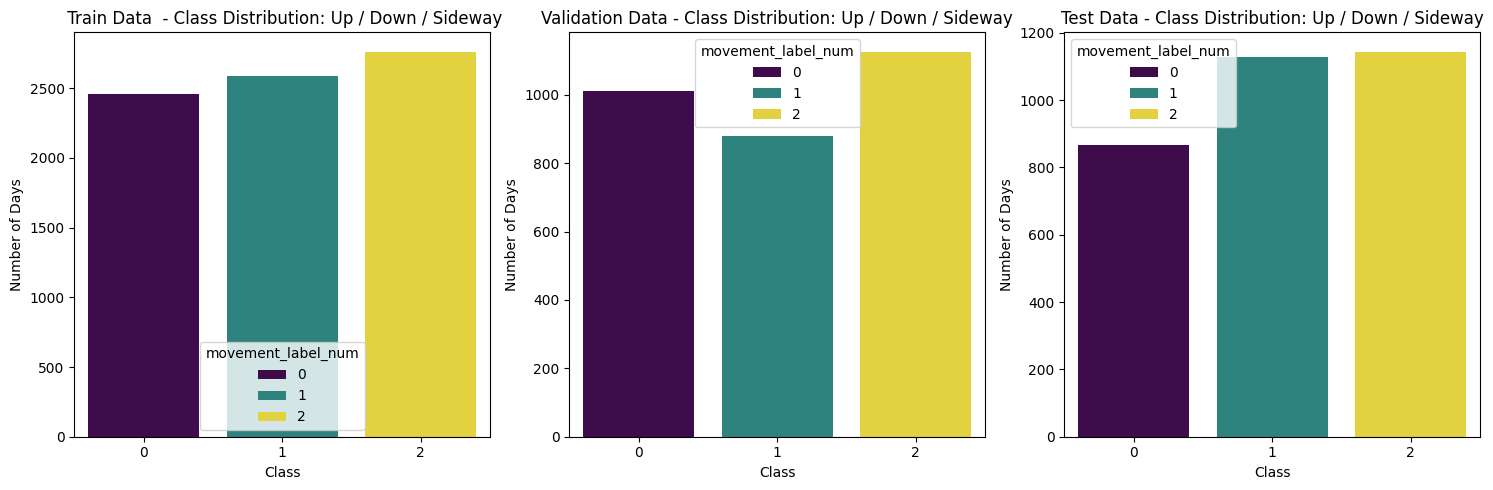

In [1501]:
# Check if any imbalance in data split

class_counts_train = train_df["movement_label_num"].value_counts()
class_percents_train = train_df["movement_label_num"].value_counts(normalize=True) * 100

class_counts_val = val_df["movement_label_num"].value_counts()
class_percents_val = val_df["movement_label_num"].value_counts(normalize=True) * 100

class_counts_test = test_df["movement_label_num"].value_counts()
class_percents_test = test_df["movement_label_num"].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=class_counts_train.index, y=class_counts_train.values,palette="viridis", hue=class_percents_train.index, ax=axes[0])
axes[0].set_xlabel("Movement Label")
axes[0].set_ylabel("Count")
axes[0].set_title(" Train Data  - Class Distribution: Up / Down / Sideway")
axes[0].set_ylabel("Number of Days")
axes[0].set_xlabel("Class")

sns.barplot(x=class_counts_val.index, y=class_counts_val.values, palette="viridis", hue=class_percents_val.index, ax=axes[1] )
axes[1].set_xlabel("Movement Label")
axes[1].set_ylabel("Count")
axes[1].set_title("Validation Data - Class Distribution: Up / Down / Sideway")
axes[1].set_ylabel("Number of Days")
axes[1].set_xlabel("Class")

sns.barplot(x=class_counts_test.index, y=class_counts_test.values, palette="viridis", hue=class_percents_test.index, ax=axes[2] )
axes[2].set_xlabel("Movement Label")
axes[2].set_ylabel("Count")
axes[2].set_title("Test Data - Class Distribution: Up / Down / Sideway")
axes[2].set_ylabel("Number of Days")
axes[2].set_xlabel("Class")


plt.tight_layout()
plt.show()

In [1502]:
# Check if balancing is needed
check_imbalance(class_percents_train.max(), class_percents_train.min())
check_imbalance(class_percents_val.max(), class_percents_val.min())
check_imbalance(class_percents_test.max(), class_percents_test.min())


Imbalance Ratio (max/min class size): 1.13
Classes are reasonably balanced. No balancing needed.

Imbalance Ratio (max/min class size): 1.28
Classes are reasonably balanced. No balancing needed.

Imbalance Ratio (max/min class size): 1.32
Classes are reasonably balanced. No balancing needed.


## Step 4: Model Development

### Step 4.1: Helper Function Declaration

#### Step 4.1.1: Constants Declaration

In [1503]:
CLASS_IDX  = (0, 1, 2)
CLASS_NAMES = ("Down", "Sideway", "Up")

#### Step 4.1.2: Utility to prepare dataset

In [1504]:
def build_dataset_for(feature_cols):

    # Add the target column to the list of columns to check and keep
    all_cols = feature_cols + ["movement_label_num"]

    def drop_na(df):
        mask_bad = df[all_cols].isna().any(axis=1)
        if mask_bad.any():
            print(f"Dropping {mask_bad.sum():,} rows with NaN due to indicators.")
        return df.loc[~mask_bad].copy()

    def check_cols_exist(df):
        available_columns = df.columns.tolist()
        valid_cols = [col for col in all_cols if col in available_columns]
        if len(valid_cols) != len(all_cols):
            missing = set(all_cols) - set(valid_cols)
            print(f"Warning: Missing columns in feature set: {missing}")
        return df[valid_cols]

    tr_na = drop_na(train_df).copy()
    va_na = drop_na(val_df).copy()
    te_na = drop_na(test_df).copy()

    tr_valid = check_cols_exist(tr_na).copy()
    va_valid = check_cols_exist(va_na).copy()
    te_valid = check_cols_exist(te_na).copy()

    y_tr = tr_valid["movement_label_num"]
    y_va = va_valid["movement_label_num"]
    y_te = te_valid["movement_label_num"]

    X_tr, X_va, X_te = tr_valid[feature_cols], va_valid[feature_cols], te_valid[feature_cols]

    return (X_tr, y_tr, tr_valid), (X_va, y_va, va_valid), (X_te, y_te, te_valid)

#### Step 4.1.3: Utility for Metrics Evaluation

In [1505]:
def eval_dict(y_true, y_pred):
    return {
        "precision_macro": float(precision_score(y_true, y_pred, average="macro")),
        "precision_weighted": float(precision_score(y_true, y_pred, average="weighted")),
        "recall_macro": float(recall_score(y_true, y_pred, average="macro")),
        "recall_weighted": float(recall_score(y_true, y_pred, average="weighted")),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro")),
        "f1_weighted": float(f1_score(y_true, y_pred, average="weighted")),
    }

#### Step 4.1.4: Utility to plot Confusion Matrix

In [1506]:
def plot_cm(y_true, y_pred, title, out_path):
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        labels=CLASS_IDX, display_labels=CLASS_NAMES,
        cmap="Blues", ax=ax
    )
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_path, dpi=140)
    plt.close(fig)

#### Step 4.1.5: Utility to plot OVR, ROC Curve

In [1507]:
def plot_ovr_curves(y_true, proba, title_prefix, out_dir):
    """
    One-vs-Rest PR & ROC curves for multiclass.
    y_true: integer labels; proba: (n_samples, n_classes)
    """
    K = len(CLASS_IDX)
    y_true_bin = np.eye(K)[y_true]  # one-hot

    # Precision–Recall
    fig_pr, ax_pr = plt.subplots(figsize=(6,4.2))
    aps = []
    for k, name in enumerate(CLASS_NAMES):
        prec, rec, _ = precision_recall_curve(y_true_bin[:,k], proba[:,k])
        ap = average_precision_score(y_true_bin[:,k], proba[:,k])
        aps.append(ap)
        ax_pr.plot(rec, prec, lw=1.8, label=f"{name} (AP={ap:.3f})")
    ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"{title_prefix} — PR (OvR)")
    ax_pr.legend(fontsize=8); fig_pr.tight_layout()
    pr_path = f"{out_dir}/pr_ovr.png"; fig_pr.savefig(pr_path, dpi=140); plt.close(fig_pr)

    # ROC
    fig_roc, ax_roc = plt.subplots(figsize=(6,4.2))
    aucs = []
    for k, name in enumerate(CLASS_NAMES):
        fpr, tpr, _ = roc_curve(y_true_bin[:,k], proba[:,k])
        auc = roc_auc_score(y_true_bin[:,k], proba[:,k])
        aucs.append(auc)
        ax_roc.plot(fpr, tpr, lw=1.8, label=f"{name} (AUC={auc:.3f})")
    ax_roc.plot([0,1],[0,1],"--",lw=1,color="gray")
    ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
    ax_roc.set_title(f"{title_prefix} — ROC (OvR)")
    ax_roc.legend(fontsize=8); fig_roc.tight_layout()
    roc_path = f"{out_dir}/roc_ovr.png"; fig_roc.savefig(roc_path, dpi=140); plt.close(fig_roc)

    return pr_path, roc_path, {"mean_ap": float(np.mean(aps)), "mean_auc": float(np.mean(aucs))}

#### Step 4.1.6: Common Training Function

In [1508]:
def safe_start_run(run_name: str, tags: dict=None, nested: bool=False):
    if not nested and mlflow.active_run() is not None:
        mlflow.end_run()
    return mlflow.start_run(run_name=run_name, nested=nested, tags=tags or {})

In [1509]:
def per_class_tables(y_true, y_pred, labels, label_names, zero_division=0):
    """
    Returns:
      counts_df  : TP/FP/FN/TN per class (+support)
      metrics_df : precision/recall/F1/support per class (+overall rows)
      cm_df      : raw confusion matrix (counts)
      cmn_df     : row-normalized confusion matrix (rates per true class)
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    total = cm.sum()

    # TP/FP/FN/TN
    TP = np.diag(cm)
    FN = cm.sum(axis=1) - TP
    FP = cm.sum(axis=0) - TP
    TN = total - (TP + FP + FN)
    support = cm.sum(axis=1)

    counts_df = pd.DataFrame({
        "class_id": labels,
        "class": [label_names[i] for i in labels],
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "support": support
    })

    # per-class metrics
    p, r, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=zero_division
    )
    metrics_df = pd.DataFrame({
        "class_id": labels,
        "class": [label_names[i] for i in labels],
        "precision": p, "recall": r, "f1": f1, "support": sup
    })

    # overall rows (macro, weighted, accuracy)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=zero_division
    )
    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=zero_division
    )
    acc = accuracy_score(y_true, y_pred)

    overall = pd.DataFrame([{
        "class": "OVERALL",
        "precision_macro": macro_p,
        "recall_macro": macro_r,
        "f1_macro": macro_f1,
        "precision_weighted": weighted_p,
        "recall_weighted": weighted_r,
        "f1_weighted": weighted_f1,
        "accuracy": acc,
        "support_total": int(total)
    }])

    with np.errstate(invalid="ignore"):
        cmn = cm / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn, nan=0.0)

    cm_df  = pd.DataFrame(cm,  index=label_names, columns=label_names)
    cmn_df = pd.DataFrame(cmn, index=label_names, columns=label_names)

    # pretty rounding for report tables
    metrics_df = metrics_df.round(4)
    overall    = overall.round(4)
    cmn_df     = cmn_df.round(4)

    return counts_df, metrics_df, overall, cm_df, cmn_df


In [1510]:
from IPython.display import Image, display

import tempfile, shutil, time

def train_eval_log(pipeline, datasets, model_name: str,
                   phase="baseline", extra_params=None):

    (X_tr, y_tr, _), (X_va, y_va, _), (X_te, y_te, _) = datasets

     # --- Decide training, validation data based phase ---
    fit_on = "train"
    eval_splits = ["train", "val", "test"]
    if phase in ("baseline", "tuning"):
        eval_splits = ["train","val"]
        X_fit, y_fit = X_tr, y_tr
    elif phase == "final":
        eval_splits = ["test"]
        fit_on = "train+val"
        X_fit = pd.concat([X_tr, X_va], axis=0)
        y_fit = np.hstack([y_tr, y_va])
    else:
        raise ValueError("phase must be 'baseline', 'tuning', or 'final'")

    ts = time.strftime("%Y%m%d-%H%M%S")
    with safe_start_run(
        run_name=f"{ts}-{phase}-{model_name}",
        tags={"model": model_name, "phase": phase}):

        tmp = tempfile.mkdtemp()

        # ---- params/context ----
        mlflow.log_param("phase", phase)
        mlflow.set_tag("phase", phase)
        mlflow.log_param("model", model_name)
        mlflow.set_tag("model", model_name)
        mlflow.log_param("fit_on", fit_on)
        mlflow.set_tag("fit_on", fit_on)
        mlflow.log_param("eval_splits", ",".join(eval_splits))
        mlflow.set_tag("eval_splits", ",".join(eval_splits))
        mlflow.log_param("n_features", X_tr.shape[1])
        mlflow.log_param("classes", ",".join(map(str, CLASS_NAMES)))
        mlflow.log_param("train_rows", X_tr.shape[0])
        mlflow.log_param("val_rows",   X_va.shape[0])
        mlflow.log_param("test_rows",  X_te.shape[0])

        # log best_params if passed in
        if extra_params is not None:
            for k, v in extra_params.items():
                mlflow.log_param(f"best_{k}", v)

        # ---- train on chosen fit set ----
        pipeline.fit(X_fit, y_fit)


        # ---- evaluate helper ----
        def eval_and_log_split(X, y, split):
            y_pred = pipeline.predict(X)

            # console summary
            macro_f1 = f1_score(y, y_pred, average="macro")
            print(f"[{model_name}] {split} macro-F1: {macro_f1:.3f}")
            print(classification_report(y, y_pred, target_names=CLASS_NAMES, digits=3))
            print("Confusion matrix:\n", confusion_matrix(y, y_pred))

            # ---- per-class tables ----
            counts_df, metrics_df, overall_df, cm_df, cmn_df = per_class_tables(
                y_true=y, y_pred=y_pred, labels=CLASS_IDX, label_names=CLASS_NAMES
            )

            # metrics to MLflow
            m = eval_dict(y, y_pred)  # accuracy, f1_macro, f1_weighted
            for k, v in m.items():
                mlflow.log_metric(f"{split}_{k}", float(v))

            # save tidy CSV artifacts for the report
            counts_df.to_csv(f"{tmp}/{split}_per_class_counts.csv", index=False)
            metrics_df.to_csv(f"{tmp}/{split}_per_class_metrics.csv", index=False)
            overall_df.to_csv(f"{tmp}/{split}_overall_metrics.csv", index=False)
            cm_df.to_csv(f"{tmp}/{split}_confusion_counts.csv")
            cmn_df.to_csv(f"{tmp}/{split}_confusion_normalized.csv")

            for fname in [
                f"{split}_per_class_counts.csv",
                f"{split}_per_class_metrics.csv",
                f"{split}_overall_metrics.csv",
                f"{split}_confusion_counts.csv",
                f"{split}_confusion_normalized.csv",
            ]:
                mlflow.log_artifact(f"{tmp}/{fname}", artifact_path=f"tables/{split}")

            return y_pred, m

        # ----  Evaluate selected splits only ----
        results = {}
        for split in eval_splits:
            if split == "train":
                yhat, m = eval_and_log_split(X_tr, y_tr, "train")
            elif split == "val":
                yhat, m = eval_and_log_split(X_va, y_va, "val")
            elif split == "test":
                yhat, m = eval_and_log_split(X_te, y_te, "test")
            else:
                raise ValueError(f"Unknown split: {split}")
            results[split] = (yhat, m)


        # ---- artifacts (plots + report) ----
        X_sample = X_fit.head(5).copy()
        try:
            # Confusion matrices for evaluated splits
            for split, (yhat, _) in results.items():
                signature = infer_signature(X_sample, yhat)
                if split == "train":
                    plot_cm(y_tr, yhat, f"{model_name} — Train CM", f"{tmp}/cm_train.png")
                    display(Image(f"{tmp}/cm_train.png"))
                elif split == "val":
                    plot_cm(y_va, yhat, f"{model_name} — Val CM",   f"{tmp}/cm_val.png")
                    display(Image(f"{tmp}/cm_val.png"))
                elif split == "test":
                    plot_cm(y_te, yhat, f"{model_name} — Test CM",  f"{tmp}/cm_test.png")
                    display(Image(f"{tmp}/cm_test.png"))

            for p in ["cm_train.png","cm_val.png","cm_test.png"]:
                pth = f"{tmp}/{p}"
                if os.path.exists(pth):
                    mlflow.log_artifact(pth, artifact_path="plots")

            # PR/ROC (only if proba available & enabled)
            if hasattr(pipeline, "predict_proba"):
                if "train" in results:
                    pr_tr, roc_tr, agg_tr = plot_ovr_curves(y_tr, pipeline.predict_proba(X_tr), f"{model_name} Train", tmp)
                if "val" in results:
                    pr_va, roc_va, agg_va = plot_ovr_curves(y_va, pipeline.predict_proba(X_va), f"{model_name} Val", tmp)
                if "test" in results:
                    pr_te, roc_te, agg_te = plot_ovr_curves(y_te, pipeline.predict_proba(X_te), f"{model_name} Test", tmp)

                for p in [locals().get("pr_tr"), locals().get("roc_tr"),
                          locals().get("pr_va"), locals().get("roc_va"),
                          locals().get("pr_te"), locals().get("roc_te")]:
                    if p:
                        mlflow.log_artifact(p, artifact_path="plots")

                for split, agg in [("train", locals().get("agg_tr")),
                                   ("val",   locals().get("agg_va")),
                                   ("test",  locals().get("agg_te"))]:
                    if agg:
                        mlflow.log_metric(f"{split}_mean_AP",  agg["mean_ap"])
                        mlflow.log_metric(f"{split}_mean_AUC", agg["mean_auc"])

            # Final text report only when we evaluate on test
            if "test" in results:
                yhat_te, _ = results["test"]
                report = classification_report(y_te, yhat_te, target_names=CLASS_NAMES, digits=4)
                with open(f"{tmp}/classification_report_test.txt", "w") as f:
                    f.write(report)
                mlflow.log_artifact(f"{tmp}/classification_report_test.txt", artifact_path="reports")

            # Persist model
            mlflow.sklearn.log_model (sk_model=pipeline,
                                      name=f"{model_name}",
                                      signature=signature,
                                      input_example=X_sample)
            mlflow.log_artifact(
                joblib.dump(pipeline, f"{model_name}.joblib")[0]
            )
        finally:
            shutil.rmtree(tmp, ignore_errors=True)

    # aggregate results for quick notebook table
    out = {k: v[1] for k, v in results.items()}
    return pipeline, out

### Step 4.2: Setting up Experiment Tracking

Setting up experiment tracking with MLFlow

In [1511]:
# Kill existing process if any
! pkill -f ngrok

In [1512]:
!ngrok config add-authtoken 2t8TIG1geBuF6yFcNXZYkkxTqzg_7qGykBf4NYA9AKwvB9u8R

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [1513]:
get_ipython().system_raw("mlflow ui --port 5000 &")

In [1514]:
# 4.1 Configure MLflow to log to Google Drive
os.makedirs(MLFLOW_PATH, exist_ok=True)

# file-based tracking (local to Drive)
#mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_tracking_uri(MLFLOW_PATH)

# will create if it doesn"t exist
mlflow.set_experiment("ITI105-SP500-Movement")

# we’ll log explicitly for full control
mlflow.sklearn.autolog(disable=True)

# Create a client to confirm tracking directory
client = MlflowClient()
print("MLflow Tracking URI:", mlflow.get_tracking_uri())

MLflow Tracking URI: /content/drive/MyDrive/NYP/ITI105/mllogs


In [1515]:
public_url = ngrok.connect(5000)
print("MLflow Tracking URL:", public_url)

MLflow Tracking URL: NgrokTunnel: "https://1f98cd48702c.ngrok-free.app" -> "http://localhost:5000"


### Step 4.3: Setting-Up Features Columns

In [1516]:
base_extra = ["daily_range", "close_to_open_gap"]
base_feats = ["Close", "log_volume"]
base_indicators = [
    "RSI",
    "MACD",
    "BB_width",
    "ATR",
    "Stoch_K"
]
base_feature_cols = base_feats + base_indicators  + base_extra

tree_feats = ["Close","log_volume"]
tree_indicators = [
    "MA20",
    "RSI",
    "MACD",
    "EMA20",
    "BB_width",
    "ATR",
    "Stoch_K"
]
tree_feature_cols = tree_feats + tree_indicators + base_extra

xgb_feature_cols = tree_feats + tree_indicators  + base_extra

FEATURE_SETS = {
    "linear": base_feature_cols,       # logistic regression
    "tree": tree_feature_cols,         # decision tree
    "rf": tree_feature_cols,           # random forest
    "xgb": xgb_feature_cols            # xgboost
}

### Step 4.4: Build Pipeline

In [1517]:
pipe_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,  random_state=42
    ))
])

pipe_tree = Pipeline([
    ("clf", DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline([
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

pipe_xgb = Pipeline([
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        subsample=1.0,
        colsample_bytree=1.0,
        n_estimators=150
    ))
])

### Step 4.4: Train


##### Logistic — baseline | #9 features #####
[20250825-183624-baseline-linear] train macro-F1: 0.552
              precision    recall  f1-score   support

        Down      0.557     0.549     0.553      2455
     Sideway      0.547     0.482     0.512      2584
          Up      0.559     0.629     0.592      2762

    accuracy                          0.555      7801
   macro avg      0.554     0.553     0.552      7801
weighted avg      0.554     0.555     0.553      7801

Confusion matrix:
 [[1347  499  609]
 [ 580 1245  759]
 [ 493  533 1736]]
[20250825-183624-baseline-linear] val macro-F1: 0.609
              precision    recall  f1-score   support

        Down      0.631     0.606     0.618      1012
     Sideway      0.575     0.595     0.585       879
          Up      0.623     0.628     0.625      1126

    accuracy                          0.611      3017
   macro avg      0.609     0.610     0.609      3017
weighted avg      0.611     0.611     0.611      3017

Confusi

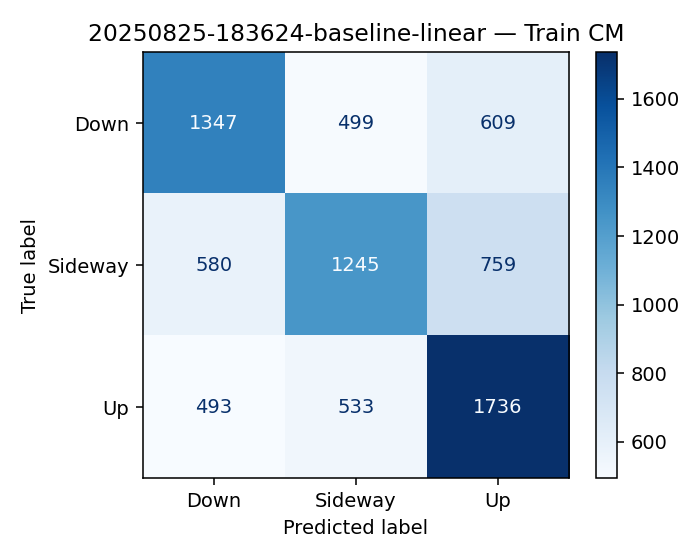

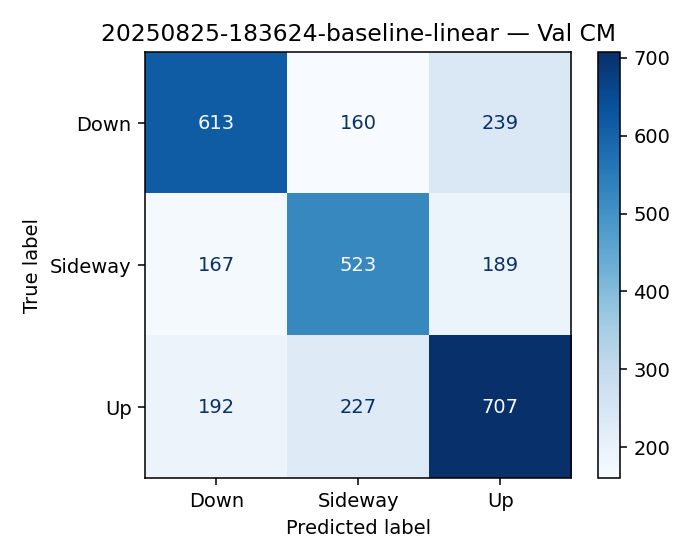

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183624-baseline-linear.joblib

##### Decision Tree — baseline | #11 features #####
[20250825-183624-baseline-tree] train macro-F1: 1.000
              precision    recall  f1-score   support

        Down      1.000     1.000     1.000      2455
     Sideway      1.000     1.000     1.000      2584
          Up      1.000     1.000     1.000      2762

    accuracy                          1.000      7801
   macro avg      1.000     1.000     1.000      7801
weighted avg      1.000     1.000     1.000      7801

Confusion matrix:
 [[2455    0    0]
 [   0 2584    0]
 [   0    0 2762]]
[20250825-183624-baseline-tree] val macro-F1: 0.545
              precision    recall  f1-score   support

        Down      0.596     0.565     0.580      1012
     Sideway      0.454     0.463     0.459       879
          Up      0.586     0.605     0.595      1126

    accuracy                          0.550      3017
   macro avg      0.

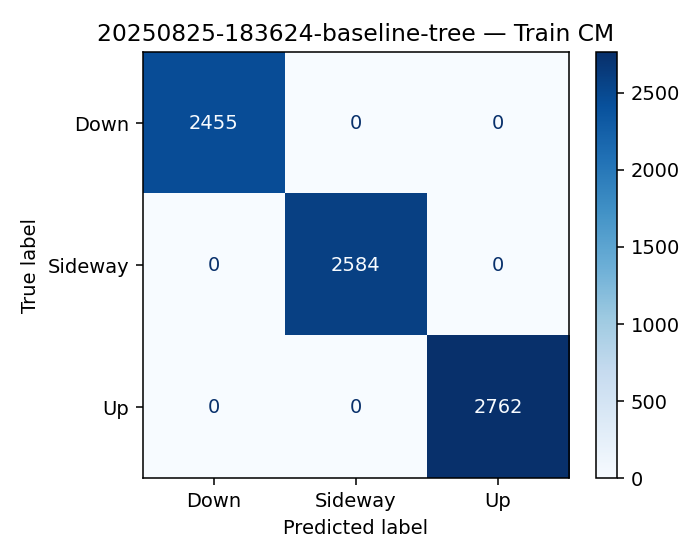

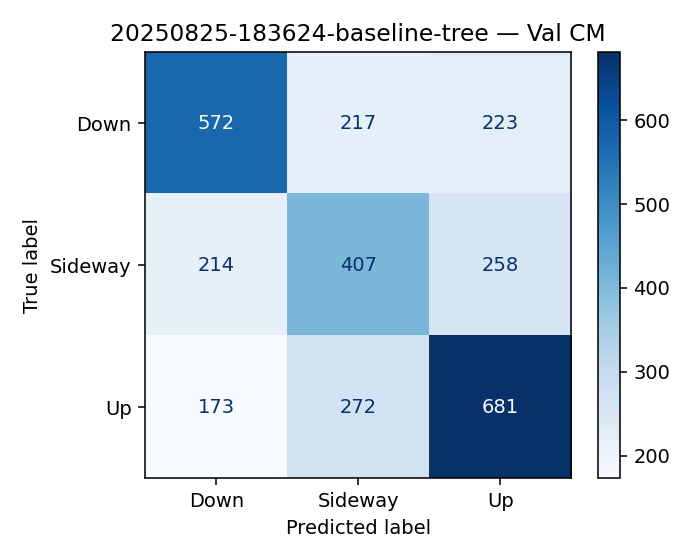

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183624-baseline-tree.joblib

##### Random Forest — baseline | #11 features #####
[20250825-183624-baseline-rf] train macro-F1: 1.000
              precision    recall  f1-score   support

        Down      1.000     1.000     1.000      2455
     Sideway      1.000     1.000     1.000      2584
          Up      1.000     1.000     1.000      2762

    accuracy                          1.000      7801
   macro avg      1.000     1.000     1.000      7801
weighted avg      1.000     1.000     1.000      7801

Confusion matrix:
 [[2455    0    0]
 [   0 2584    0]
 [   0    0 2762]]
[20250825-183624-baseline-rf] val macro-F1: 0.574
              precision    recall  f1-score   support

        Down      0.614     0.721     0.664      1012
     Sideway      0.589     0.319     0.414       879
          Up      0.590     0.710     0.644      1126

    accuracy                          0.600      3017
   macro avg      0.598   

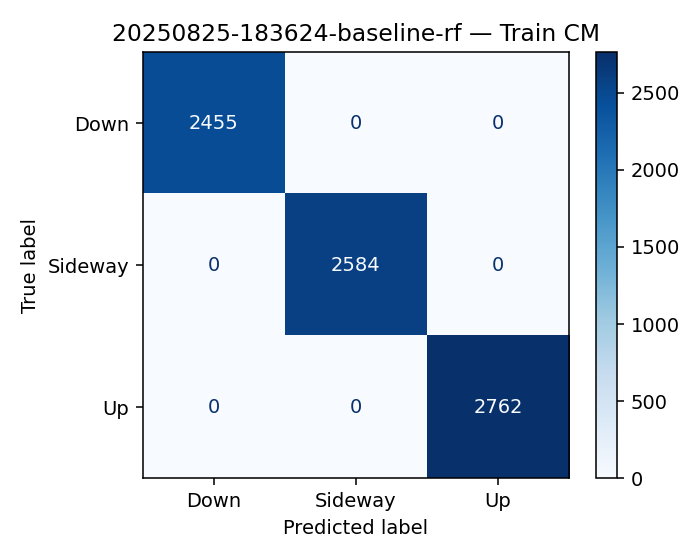

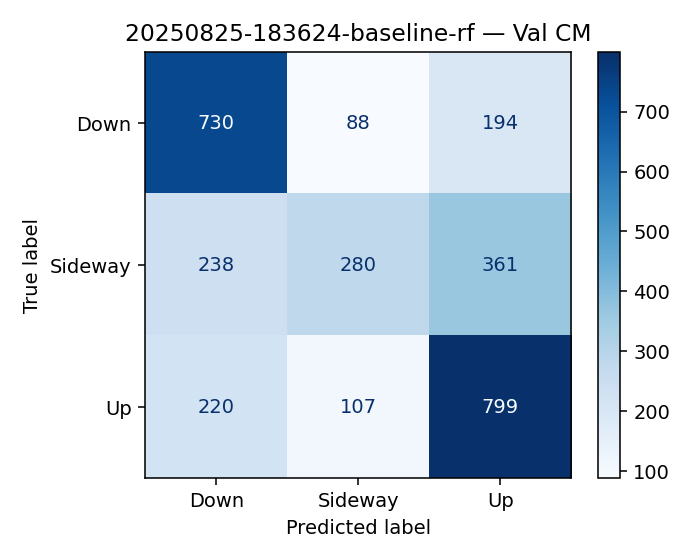

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183624-baseline-rf.joblib

##### XGBoost — baseline | #11 features #####
[20250825-183624-baseline-xgb] train macro-F1: 0.981
              precision    recall  f1-score   support

        Down      0.986     0.983     0.985      2455
     Sideway      0.972     0.982     0.977      2584
          Up      0.986     0.979     0.983      2762

    accuracy                          0.981      7801
   macro avg      0.981     0.981     0.981      7801
weighted avg      0.981     0.981     0.981      7801

Confusion matrix:
 [[2414   29   12]
 [  21 2537   26]
 [  13   45 2704]]
[20250825-183624-baseline-xgb] val macro-F1: 0.605
              precision    recall  f1-score   support

        Down      0.720     0.547     0.622      1012
     Sideway      0.555     0.506     0.529       879
          Up      0.589     0.757     0.663      1126

    accuracy                          0.614      3017
   macro avg      0.621     0.60

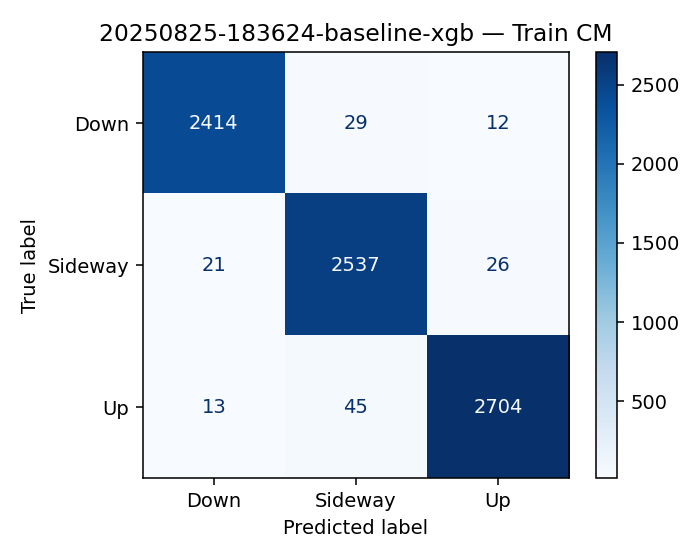

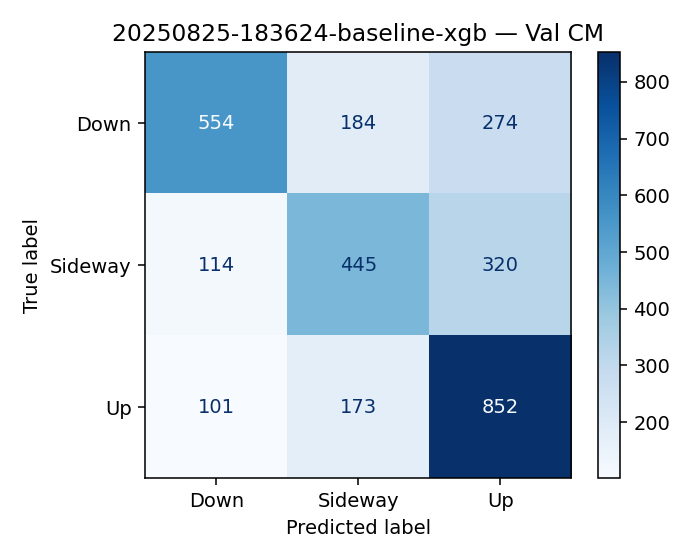

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183624-baseline-xgb.joblib


,Model,n_features,Train macro-F1 (base),Train acc (base),Val macro-F1 (base),Val acc (base)
0,XGBoost,11,0.981323,0.981284,0.604696,0.613523
1,Logistic,9,0.552247,0.554801,0.609338,0.610872
2,Random Forest,11,1.000000,1.000000,0.573860,0.599602
3,Decision Tree,11,1.000000,1.000000,0.544762,0.550215


In [1518]:
# Train & evaluate all models
phase = "baseline"
PIPES = {
    "Logistic":         (pipe_linear, "linear"),
    "Decision Tree":    (pipe_tree,  "tree"),
    "Random Forest":    (pipe_rf,    "rf"),
    "XGBoost":          (pipe_xgb,   "xgb")
}

baseline_rows = []
fitted_baseline = {}

# take the timestamp - to identify the cycle
ts = time.strftime("%Y%m%d-%H%M%S")

for name, (pipe, key) in PIPES.items():

    # variables declaration
    model_name = f"{ts}-{phase}-{key}"

    # prepare training dataset
    cols = FEATURE_SETS[key]
    ds = build_dataset_for(cols)

    # start training
    print(f"\n##### {name} — baseline | #{len(cols)} features #####")
    fitted, metrics = train_eval_log(
        pipeline=pipe,
        datasets=ds,
        model_name=model_name,
        phase=phase
    )

    # save model
    meta = {
        "model_name": f"{model_name}",
        "created_by": "Isak Rabin",
        "feature_set_key": key,
        "features": FEATURE_SETS[key],
        "classes": list(CLASS_NAMES),
        "class_indices": list(range(len(CLASS_NAMES))),
        "random_state": 42
    }
    joblib.dump(fitted, f"{MODELS_PATH}/{model_name}.joblib", compress=3)
    with open( f"{MODELS_PATH}/{model_name}.metadata.json", "w") as f:
        json.dump(meta, f, indent=2)
    print("Saved:", f"{MODELS_PATH}/{model_name}.joblib")

    # store test result - reporting
    fitted_baseline[name] = fitted
    baseline_rows.append({
        "Model": name,
        "n_features": len(cols),
        "Train macro-F1 (base)":  metrics["train"]["f1_macro"],
        "Train acc (base)":       metrics["train"]["accuracy"],
        "Val macro-F1 (base)":  metrics["val"]["f1_macro"],
        "Val acc (base)":       metrics["val"]["accuracy"]
    })

# save all training results, display on console
baseline_df = (pd.DataFrame(baseline_rows)
               .sort_values("Val macro-F1 (base)", ascending=False)
               .sort_values("Val acc (base)", ascending=False)
               .reset_index(drop=True))
baseline_df.to_csv(f"{ts}-{phase}-results.csv", index=False)

baseline_df

### Step 4.5 Tuning

In [1519]:
grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"]
}

grid_dt = {
    "clf__max_depth": [3, 5, 7],
    "clf__min_samples_split": [0.01, 0.02],
    "clf__min_samples_leaf": [0.005, 0.01],
    "clf__criterion": ["gini"],
}

grid_rf = {
    "clf__n_estimators": [200, 300],
    "clf__max_depth": [None, 12],
    "clf__max_features": ["sqrt"],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__min_samples_split": [2, 5, 10]
}

grid_xgb = {
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.03, 0.1],
    "clf__max_depth": [4, 6],
    "clf__subsample": [0.8, 1.0],
    "clf__min_child_weight": [1, 3],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0],
    "clf__reg_alpha": [0, 0.1]
}


In [1520]:
def run_grid(name, base_pipe, grid, X, y, scoring="f1_macro", n_jobs=-1):

    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(estimator=base_pipe, param_grid=grid,
                      scoring=scoring, cv=tscv, n_jobs=n_jobs,
                      verbose=1, refit=True)

    ts = time.strftime("%Y%m%d-%H%M%S")
    with mlflow.start_run(run_name=f"{ts}-gridsearch-{name}"):
        mlflow.log_param("grid_model", name)
        mlflow.log_param("scoring", scoring)

        # run fine-tuning
        gs.fit(X, y)

        # GridSearchCV table (top 20)
        cvres = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
        top_path = f"{name}_grid_top20.csv"
        cvres.head(20).to_csv(top_path, index=False)
        mlflow.log_artifact(top_path, artifact_path="grid")

        # Best params/score
        mlflow.log_metric("best_cv_f1_macro", float(gs.best_score_))
        for k, v in gs.best_params_.items():
            mlflow.log_param(f"best_{k}", v)

    print(f"[{name}] best f1_macro (GridSearchCV): {gs.best_score_:.4f}; params: {gs.best_params_}")

    return gs.best_estimator_, gs.best_params_, gs.best_score_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Logistic] best f1_macro (GridSearchCV): 0.5474; params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

##### Logistic — tuned retrain (fit on train+val) #####
[20250825-183737-tuning-linear] train macro-F1: 0.528
              precision    recall  f1-score   support

        Down      0.540     0.554     0.547      2455
     Sideway      0.520     0.403     0.454      2584
          Up      0.538     0.639     0.584      2762

    accuracy                          0.534      7801
   macro avg      0.533     0.532     0.528      7801
weighted avg      0.533     0.534     0.529      7801

Confusion matrix:
 [[1360  468  627]
 [ 652 1041  891]
 [ 505  491 1766]]
[20250825-183737-tuning-linear] val macro-F1: 0.612
              precision    recall  f1-score   support

        Down      0.617     0.634     0.626      1012
     Sideway      0.588     0.554     0.571       879
          Up      0.632     0.645     0

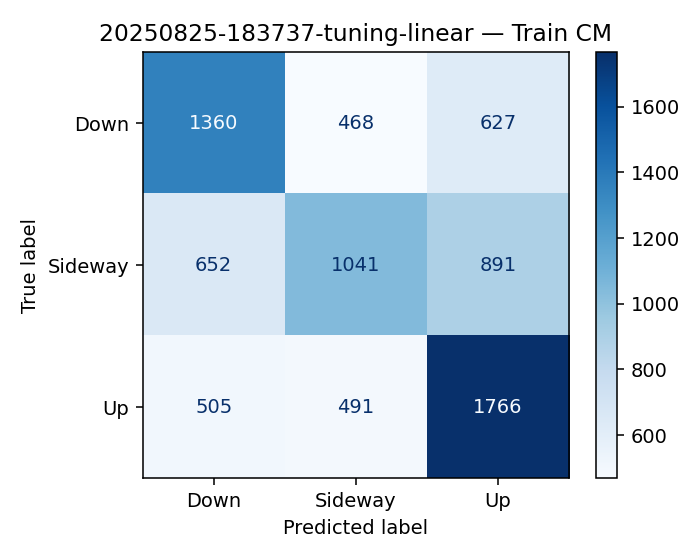

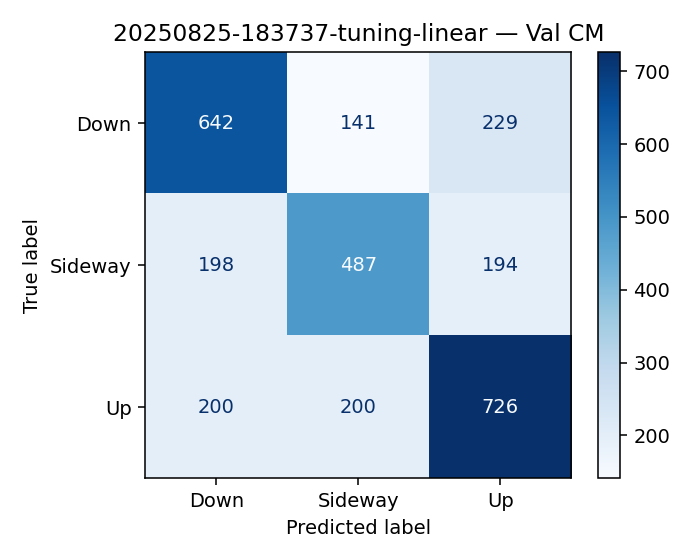

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183737-tuning-linear.joblib
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Decision Tree] best f1_macro (GridSearchCV): 0.5080; params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 0.01}

##### Decision Tree — tuned retrain (fit on train+val) #####
[20250825-183737-tuning-tree] train macro-F1: 0.565
              precision    recall  f1-score   support

        Down      0.564     0.585     0.574      2455
     Sideway      0.535     0.475     0.503      2584
          Up      0.596     0.639     0.617      2762

    accuracy                          0.568      7801
   macro avg      0.565     0.566     0.565      7801
weighted avg      0.566     0.568     0.566      7801

Confusion matrix:
 [[1436  532  487]
 [ 648 1228  708]
 [ 463  535 1764]]
[20250825-183737-tuning-tree] val macro-F1: 0.413
              precision    recall  f1-score   support



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

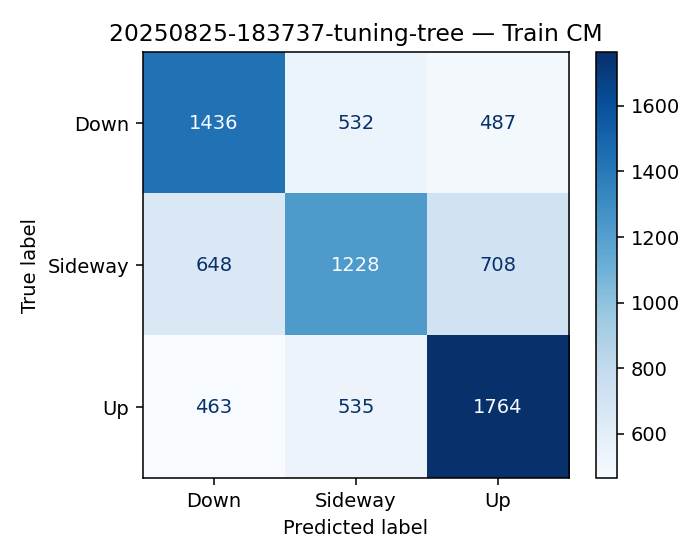

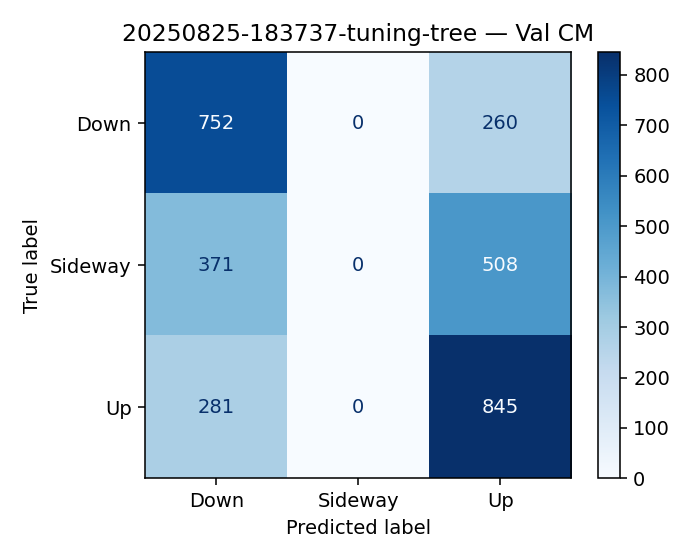

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183737-tuning-tree.joblib
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Random Forest] best f1_macro (GridSearchCV): 0.5567; params: {'clf__max_depth': 12, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}

##### Random Forest — tuned retrain (fit on train+val) #####
[20250825-183737-tuning-rf] train macro-F1: 0.816
              precision    recall  f1-score   support

        Down      0.816     0.812     0.814      2455
     Sideway      0.778     0.826     0.802      2584
          Up      0.856     0.810     0.832      2762

    accuracy                          0.816      7801
   macro avg      0.817     0.816     0.816      7801
weighted avg      0.817     0.816     0.816      7801

Confusion matrix:
 [[1994  302  159]
 [ 231 2135  218]
 [ 220  306 2236]]
[20250825-183737-tuning-rf] val macro-F1: 0.551
              precision    recall  

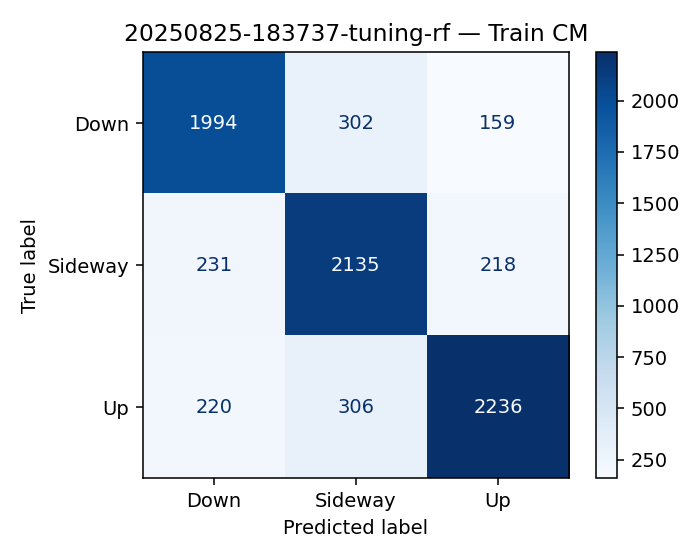

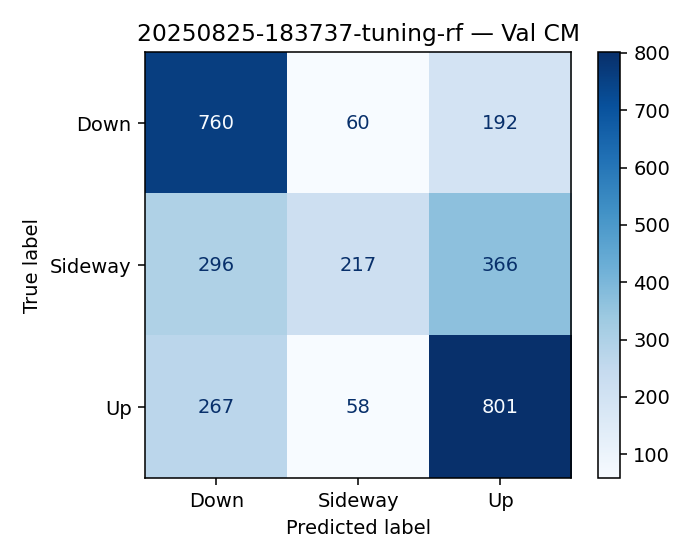

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183737-tuning-rf.joblib
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[XGBoost] best f1_macro (GridSearchCV): 0.6035; params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 200, 'clf__reg_alpha': 0, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8}

##### XGBoost — tuned retrain (fit on train+val) #####
[20250825-183737-tuning-xgb] train macro-F1: 0.759
              precision    recall  f1-score   support

        Down      0.760     0.774     0.767      2455
     Sideway      0.719     0.753     0.735      2584
          Up      0.800     0.751     0.774      2762

    accuracy                          0.759      7801
   macro avg      0.759     0.759     0.759      7801
weighted avg      0.760     0.759     0.759      7801

Confusion matrix:
 [[1900  349  206]
 [ 325 1945  314]
 [ 275  413 2074]]
[20250825-183737-tuning-xgb] 

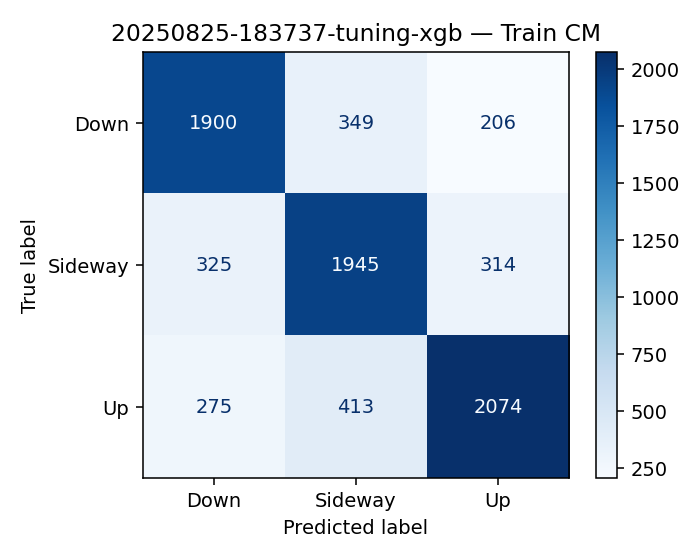

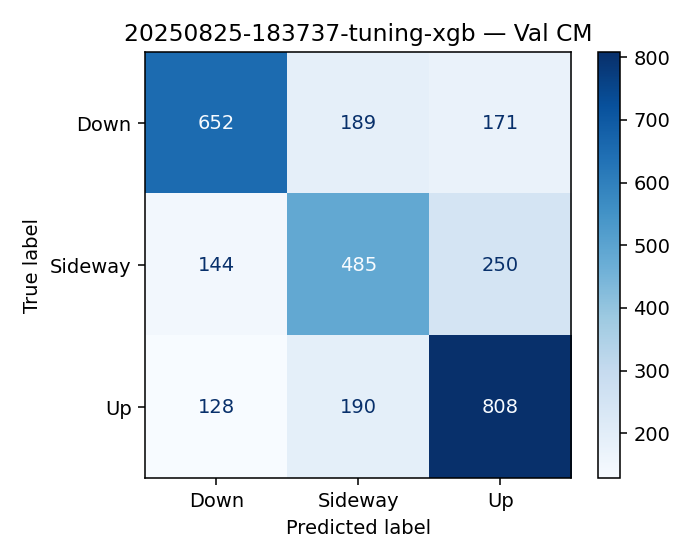

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-183737-tuning-xgb.joblib


,Model,n_features,Train macro-F1 (tuned),Train acc (tuned),Val macro-F1 (tuned),Val acc (tuned)
0,20250825-183737-tuning-xgb,11,0.758857,0.758749,0.638755,0.644680
1,20250825-183737-tuning-linear,9,0.528480,0.534162,0.611521,0.614849
2,20250825-183737-tuning-rf,11,0.815818,0.815921,0.551042,0.589327
3,20250825-183737-tuning-tree,11,0.564743,0.567620,0.413177,0.529334


In [1521]:
# Tuned, Re-Train & Re-evaluate all models
phase = "tuning"
TUNED_PIPES = {
    "Logistic":         (pipe_linear, grid_lr,  "linear"),
    "Decision Tree":    (pipe_tree,   grid_dt,  "tree"),
    "Random Forest":    (pipe_rf,     grid_rf,  "rf"),
    "XGBoost":           (pipe_xgb,    grid_xgb, "xgb"),
}

tuned_rows = []
best_estimators = {}

# take the timestamp - to identify the cycle
ts = time.strftime("%Y%m%d-%H%M%S")
for name, (base_pipe, grid, key) in TUNED_PIPES.items():

    # variables declaration
    model_name = f"{ts}-{phase}-{key}"

    # prepare dataset for tuning
    (X_tr, y_tr, _), (X_va, y_va, _), (X_te, y_te, _) = build_dataset_for(FEATURE_SETS[key])

    # find the best parameter
    best_est, best_params, best_cv = run_grid(
        name, base_pipe, grid, X_tr, y_tr, scoring="f1_macro"
    )
    best_estimators[name] = (best_est, best_params, key)

    # re-train
    print(f"\n##### {name} — tuned retrain (fit on train+val) #####")
    ds = ((X_tr, y_tr, None), (X_va, y_va, None), (X_te, y_te, None))

    fitted, metrics = train_eval_log(
        pipeline=best_est,
        datasets=ds,
        model_name=model_name,
        phase=phase,
        extra_params=best_params
    )

    # save model
    meta = {
        "model_name": f"{model_name}",
        "created_by": "Isak Rabin",
        "feature_set_key": key,
        "features": FEATURE_SETS[key],
        "classes": list(CLASS_NAMES),
        "class_indices": list(range(len(CLASS_NAMES))),
        "random_state": 42
    }
    joblib.dump(fitted, f"{MODELS_PATH}/{model_name}.joblib", compress=3)
    with open(f"{MODELS_PATH}/{model_name}.metadata.json", "w") as f:
        json.dump(meta, f, indent=2)
    print("Saved:", f"{MODELS_PATH}/{model_name}.joblib")

    # store test result - reporting
    tuned_rows.append({
        "Model": model_name,
        "n_features": len(FEATURE_SETS[key]),
        "Train macro-F1 (tuned)":  metrics["train"]["f1_macro"],
        "Train acc (tuned)":       metrics["train"]["accuracy"],
        "Val macro-F1 (tuned)":  metrics["val"]["f1_macro"],
        "Val acc (tuned)":       metrics["val"]["accuracy"]
    })

# save all training results, display on console
tuned_df = (pd.DataFrame(tuned_rows)
            .sort_values("Val macro-F1 (tuned)", ascending=False)
            .sort_values("Val acc (tuned)", ascending=False)
            .reset_index(drop=True))
tuned_df.to_csv(f"{ts}-{phase}-results.csv", index=False)

tuned_df

### Step 4.6: Final Test

In [1522]:
def finalize_and_test(best_estimators, feature_sets,
                      build_dataset_for, train_eval_log):

    # variables declaration
    ts = time.strftime("%Y%m%d-%H%M%S")
    phase = "final"

    ds_cache = {}
    def get_ds(k):
        if k not in ds_cache:
            ds_cache[k] = build_dataset_for(feature_sets[k])
        return ds_cache[k]

    test_rows, final_models = [], {}
    for name, (best_est, best_params, key) in best_estimators.items():

        # variables declaration
        model_name = f"{ts}-{phase}-{key}"

        # prepare dataset
        ds = get_ds(key)

        # final test
        print(f"\n##### {name} — FINAL #####")
        fitted, metrics = train_eval_log(
            pipeline=best_est,
            datasets=ds,
            model_name=model_name,
            phase=phase,
            extra_params=best_params
        )

        # save model
        meta = {
            "model_name": f"{model_name}",
            "created_by": "Isak Rabin",
            "feature_set_key": key,
            "features": FEATURE_SETS[key],
            "classes": list(CLASS_NAMES),
            "class_indices": list(range(len(CLASS_NAMES))),
            "random_state": 42
        }
        joblib.dump(fitted, f"{MODELS_PATH}/{model_name}.joblib", compress=3)
        with open(f"{MODELS_PATH}/{model_name}.metadata.json", "w") as f:
            json.dump(meta, f, indent=2)
        print("Saved:", f"{MODELS_PATH}/{model_name}.joblib")

        # save result
        final_models[name] = fitted
        test_rows.append({
            "Model": name,
            "n_features": len(feature_sets[key]),
            "Test macro-F1 (test)": metrics["test"]["f1_macro"],
            "Test acc (test)":      metrics["test"]["accuracy"]
        })

    # generate report, and display on console
    test_df = (pd.DataFrame(test_rows)
               .sort_values(["Test macro-F1 (test)","Test acc (test)"], ascending=[False, False])
               .reset_index(drop=True))
    test_df.to_csv(f"{ts}-{phase}-results.csv", index=False)

    return test_df, final_models


##### Logistic — FINAL #####
[20250825-194111-final-linear] test macro-F1: 0.639
              precision    recall  f1-score   support

        Down      0.616     0.592     0.604       868
     Sideway      0.652     0.647     0.649      1128
          Up      0.652     0.676     0.664      1144

    accuracy                          0.642      3140
   macro avg      0.640     0.638     0.639      3140
weighted avg      0.642     0.642     0.642      3140

Confusion matrix:
 [[514 166 188]
 [173 730 225]
 [147 224 773]]


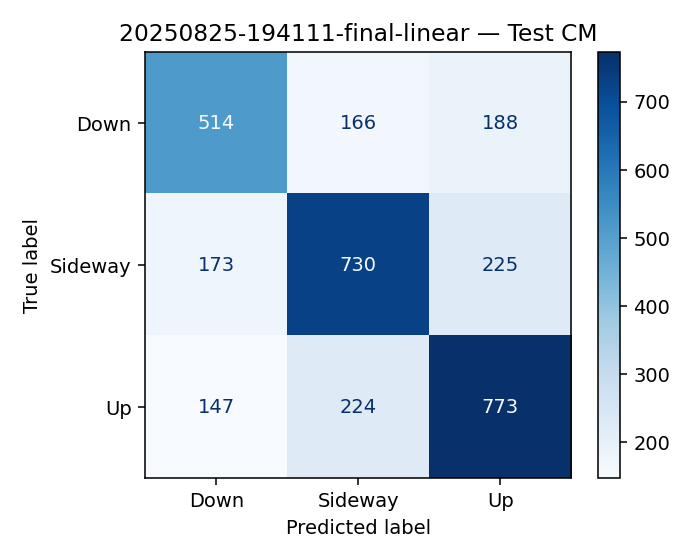

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-194111-final-linear.joblib

##### Decision Tree — FINAL #####
[20250825-194111-final-tree] test macro-F1: 0.544
              precision    recall  f1-score   support

        Down      0.531     0.689     0.600       868
     Sideway      0.748     0.277     0.404      1128
          Up      0.539     0.752     0.628      1144

    accuracy                          0.564      3140
   macro avg      0.606     0.572     0.544      3140
weighted avg      0.612     0.564     0.540      3140

Confusion matrix:
 [[598  43 227]
 [306 312 510]
 [222  62 860]]


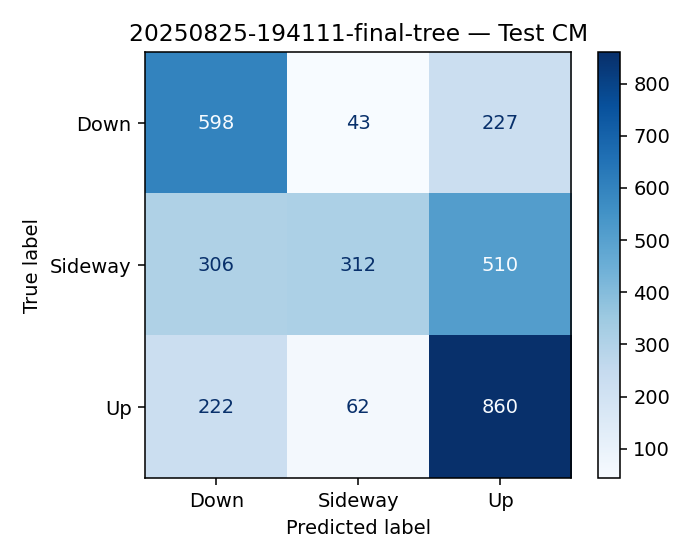

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-194111-final-tree.joblib

##### Random Forest — FINAL #####
[20250825-194111-final-rf] test macro-F1: 0.559
              precision    recall  f1-score   support

        Down      0.668     0.673     0.670       868
     Sideway      0.806     0.210     0.333      1128
          Up      0.531     0.915     0.672      1144

    accuracy                          0.595      3140
   macro avg      0.668     0.599     0.559      3140
weighted avg      0.668     0.595     0.550      3140

Confusion matrix:
 [[ 584   44  240]
 [ 206  237  685]
 [  84   13 1047]]


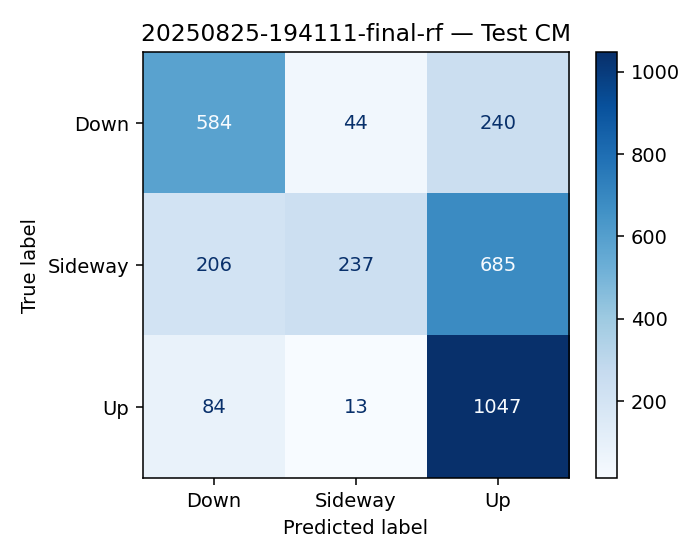

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-194111-final-rf.joblib

##### XGBoost — FINAL #####
[20250825-194111-final-xgb] test macro-F1: 0.576
              precision    recall  f1-score   support

        Down      0.663     0.680     0.671       868
     Sideway      0.776     0.252     0.380      1128
          Up      0.545     0.897     0.678      1144

    accuracy                          0.605      3140
   macro avg      0.661     0.609     0.576      3140
weighted avg      0.660     0.605     0.569      3140

Confusion matrix:
 [[ 590   60  218]
 [ 204  284  640]
 [  96   22 1026]]


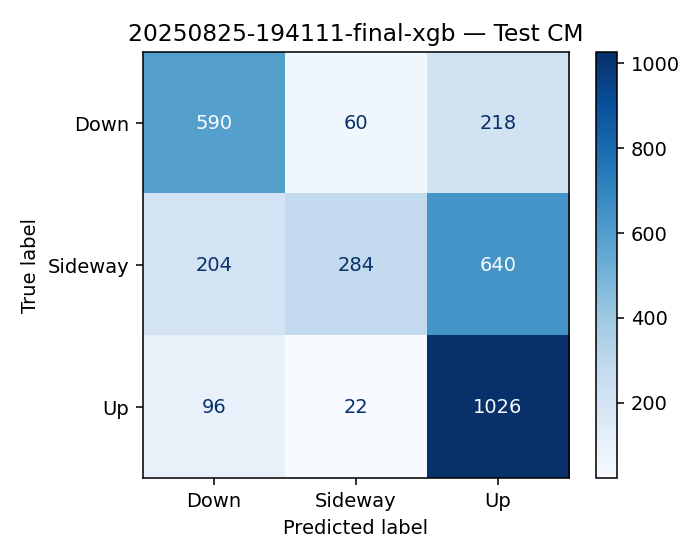

Saved: /content/drive/MyDrive/NYP/ITI105/mllogs/models/20250825-194111-final-xgb.joblib


,Model,n_features,Test macro-F1 (test),Test acc (test)
0,Logistic,9,0.638994,0.642357
1,XGBoost,11,0.576360,0.605096
2,Random Forest,11,0.558614,0.594904
3,Decision Tree,11,0.543730,0.563694


In [1523]:
# save all training results, display on console
test_df, final_models = finalize_and_test(
    best_estimators=best_estimators,
    feature_sets=FEATURE_SETS,
    build_dataset_for=build_dataset_for,
    train_eval_log=train_eval_log
)

test_df

### Step 4.7: Stop Tracking

In [1524]:
# Call this to close the current tunnel/session cleanly
try:
    ngrok.disconnect(http_tunnel.public_url)
except Exception:
    pass
ngrok.kill()

### Step 4.8: Training Summary

# Summary